# SUV Purchase Predictor

In this notebook, we will train a logistic regression model to predict whether or not one should buy an SUV given their age, gender, and annual salary. The purpose of this programming exercise is to expose students to the **PyTorch** framework, as well as diving deeper into the architecture of learning algorithms.

## Introduction

Suppose you are thinking about buying an SUV, however you are not sure whether or not you should drop the money on a new car. You decide to make a classifier that learns people's decisions in the past to aid you in your own decision. You are given a dataset with the features `UserID`, `Gender`, `Age`, `EstimatedSalary`, as well as your label `Purchased`.

## Unpacking the dataset

In [1]:
#!unzip colab
!pip install numpy pandas torch=1.8.1 sklearn matplotlib seaborn


import numpy as np
import pandas as pd
import torch

pd.set_option("display.max_columns", None)
np.random.seed(10)

ERROR: Invalid requirement: 'torch=1.8.1'
Hint: = is not a valid operator. Did you mean == ?
You should consider upgrading via the '/home/zonyyu/Documents/Programming Projects/Project Files/M2MTech/AI Deep Dive 1/workshop-2-logistic-regression/env/bin/python3 -m pip install --upgrade pip' command.


In [2]:
data = pd.read_csv('datasets/SUV_Purchase.csv')
data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [3]:
# Converting Gender into categorical values
gender_dummies = pd.get_dummies(data['Gender'])
gender_dummies

,Female,Male
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
395,1,0
396,0,1
397,1,0
398,0,1


In [4]:
# let 0 = male, 1 = female
data['gender_num'] = gender_dummies['Female']
data

,User ID,Gender,Age,EstimatedSalary,Purchased,gender_num
0,15624510,Male,19,19000,0,0
1,15810944,Male,35,20000,0,0
2,15668575,Female,26,43000,0,1
3,15603246,Female,27,57000,0,1
4,15804002,Male,19,76000,0,0
...,...,...,...,...,...,...
395,15691863,Female,46,41000,1,1
396,15706071,Male,51,23000,1,0
397,15654296,Female,50,20000,1,1
398,15755018,Male,36,33000,0,0


In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# Data selection
features = data[['Age', 'EstimatedSalary', 'gender_num']].to_numpy()
labels = data[['Purchased']].to_numpy()

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2)
poly= PolynomialFeatures(degree=3)

# Create Polynomial Features
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

# Display shapes
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# Convert into pytorch tensors 
X_train_t = torch.from_numpy(X_train).float()
Y_train_t = torch.from_numpy(Y_train).float()

(320, 20)
(320, 1)
(80, 20)
(80, 1)


In [6]:
# Number of positive and negative (females and males)
positives = np.sum(data['Purchased'].to_numpy())
negatives = int(len(data.index) - positives)

print(f'Num of positives: {positives}')
print(f'Num of negatives: {negatives}\n')

# Calculate Class Weights to balance classes
pos_weight = len(data.index)/(2 * positives)
neg_weight = len(data.index)/(2 * negatives)

print(f"positive weight: {pos_weight}")
print(f"negative weight: {neg_weight}")


def class_weights(Y_train, pos_weight, neg_weight):
    """
    calculates the weights for each and every training example
    Args:
        Y_train: training labels
        pos_weight: Weight of positive labels
        neg_weight: Weight of negative labels
    Returns:
        weights: an np.array where its shape is identical to Y_train
    """
    
    pos_mask = Y_train.astype(bool)
    neg_mask = ~Y_train.astype(bool)

    pos_mask = pos_mask.astype(np.float32) * pos_weight

    neg_mask = neg_mask.astype(np.float32) * neg_weight
    return pos_mask + neg_mask
    

weights = class_weights(Y_train, pos_weight, neg_weight)
print(weights.shape)

Num of positives: 143
Num of negatives: 257

positive weight: 1.3986013986013985
negative weight: 0.7782101167315175
(320, 1)


## Training the Logistic Regression Model

Recall from the Topic 2 Notebook, Logistic Regression differs from Linear Regression in terms of the Activation function (sigmoid) and the Cost function (BCE). Most other aspects are similar. Here we will use the `BatchNorm1d` layer to normalize the inputs.

In [7]:
from torch.nn import Module, Linear, BCELoss, BatchNorm1d
from torch.optim import SGD

class Logreg(Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear  = Linear(input_dim, output_dim)
        self.bn = BatchNorm1d(input_dim)
        
    def forward(self, x):
        # Batch norm is used solely to normalize the inputs
        x = self.bn(x)
        z = self.linear(x)
        y_pred = torch.sigmoid(z)
        return y_pred
    
    def fit(self, X_train, Y_train, epochs, loss_func, opt):
        """
        Trains the model.
        Args:
            X_train, Y_train: training set and labels. Must be 
                            torch.tensor
            epochs: The number of passes over your training dataset
            loss_func: optimizing criterion
            opt: optimizing algorithm
        """
        for i in range(epochs):
            self.train()
            opt.zero_grad()
        
            Y_pred = self(X_train)
            loss = loss_func(Y_pred, Y_train)
            
            print(f"iteration {i+1}: loss: {loss.item()}")
        
            loss.backward()
            opt.step()

            del Y_pred
            del loss

In [8]:
LEARNING_RATE = 0.02
EPOCHS = 50000

# Initializing a model
model = Logreg(X_train.shape[1], 1).cpu()

# Optimizing criterion and optimizing algorithm
# ignore talking about momentum and nesterov
criterion = BCELoss(weight=torch.from_numpy(weights).float())
optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)


model.fit(X_train_t, Y_train_t, EPOCHS, criterion, optimizer)

iteration 1: loss: 0.617245614528656
iteration 2: loss: 0.6049179434776306
iteration 3: loss: 0.5885602235794067
iteration 4: loss: 0.5696359872817993
iteration 5: loss: 0.549451470375061
iteration 6: loss: 0.5290752649307251
iteration 7: loss: 0.509310245513916
iteration 8: loss: 0.490705668926239
iteration 9: loss: 0.4735916256904602
iteration 10: loss: 0.45812469720840454
iteration 11: loss: 0.4443342089653015
iteration 12: loss: 0.4321630895137787
iteration 13: loss: 0.42150139808654785
iteration 14: loss: 0.4122115969657898
iteration 15: loss: 0.40414586663246155
iteration 16: loss: 0.397158145904541
iteration 17: loss: 0.39111095666885376
iteration 18: loss: 0.38587865233421326
iteration 19: loss: 0.38134950399398804
iteration 20: loss: 0.3774251639842987
iteration 21: loss: 0.3740202486515045
iteration 22: loss: 0.3710610270500183
iteration 23: loss: 0.3684841990470886
iteration 24: loss: 0.36623531579971313
iteration 25: loss: 0.36426782608032227
iteration 26: loss: 0.362541675

iteration 243: loss: 0.3035806715488434
iteration 244: loss: 0.30346617102622986
iteration 245: loss: 0.3033520579338074
iteration 246: loss: 0.30323880910873413
iteration 247: loss: 0.30312618613243103
iteration 248: loss: 0.30301398038864136
iteration 249: loss: 0.302902489900589
iteration 250: loss: 0.3027915358543396
iteration 251: loss: 0.30268120765686035
iteration 252: loss: 0.30257123708724976
iteration 253: loss: 0.30246201157569885
iteration 254: loss: 0.30235350131988525
iteration 255: loss: 0.3022454082965851
iteration 256: loss: 0.3021378219127655
iteration 257: loss: 0.3020308017730713
iteration 258: loss: 0.3019244968891144
iteration 259: loss: 0.3018186390399933
iteration 260: loss: 0.3017132878303528
iteration 261: loss: 0.30160853266716003
iteration 262: loss: 0.30150437355041504
iteration 263: loss: 0.3014008104801178
iteration 264: loss: 0.3012976050376892
iteration 265: loss: 0.3011949956417084
iteration 266: loss: 0.30109304189682007
iteration 267: loss: 0.3009915

iteration 536: loss: 0.28554949164390564
iteration 537: loss: 0.28551721572875977
iteration 538: loss: 0.28548508882522583
iteration 539: loss: 0.28545325994491577
iteration 540: loss: 0.28542131185531616
iteration 541: loss: 0.28538942337036133
iteration 542: loss: 0.2853577435016632
iteration 543: loss: 0.28532612323760986
iteration 544: loss: 0.2852945923805237
iteration 545: loss: 0.28526318073272705
iteration 546: loss: 0.28523164987564087
iteration 547: loss: 0.2852005064487457
iteration 548: loss: 0.28516942262649536
iteration 549: loss: 0.28513818979263306
iteration 550: loss: 0.285107284784317
iteration 551: loss: 0.2850762903690338
iteration 552: loss: 0.2850455641746521
iteration 553: loss: 0.285014808177948
iteration 554: loss: 0.2849840819835663
iteration 555: loss: 0.28495341539382935
iteration 556: loss: 0.2849231958389282
iteration 557: loss: 0.2848927974700928
iteration 558: loss: 0.2848624587059021
iteration 559: loss: 0.2848320007324219
iteration 560: loss: 0.2848019

iteration 822: loss: 0.2786838114261627
iteration 823: loss: 0.278664767742157
iteration 824: loss: 0.27864569425582886
iteration 825: loss: 0.27862682938575745
iteration 826: loss: 0.2786078453063965
iteration 827: loss: 0.2785888612270355
iteration 828: loss: 0.2785699963569641
iteration 829: loss: 0.2785510718822479
iteration 830: loss: 0.27853208780288696
iteration 831: loss: 0.27851325273513794
iteration 832: loss: 0.2784945070743561
iteration 833: loss: 0.27847570180892944
iteration 834: loss: 0.27845677733421326
iteration 835: loss: 0.2784380614757538
iteration 836: loss: 0.2784194052219391
iteration 837: loss: 0.2784006595611572
iteration 838: loss: 0.2783820629119873
iteration 839: loss: 0.27836328744888306
iteration 840: loss: 0.2783445715904236
iteration 841: loss: 0.27832600474357605
iteration 842: loss: 0.27830737829208374
iteration 843: loss: 0.27828869223594666
iteration 844: loss: 0.27827024459838867
iteration 845: loss: 0.27825164794921875
iteration 846: loss: 0.278233

iteration 1156: loss: 0.2733287215232849
iteration 1157: loss: 0.2733154892921448
iteration 1158: loss: 0.2733019292354584
iteration 1159: loss: 0.2732885479927063
iteration 1160: loss: 0.2732751965522766
iteration 1161: loss: 0.27326205372810364
iteration 1162: loss: 0.2732486128807068
iteration 1163: loss: 0.2732353210449219
iteration 1164: loss: 0.2732219398021698
iteration 1165: loss: 0.27320870757102966
iteration 1166: loss: 0.2731953561306
iteration 1167: loss: 0.273182213306427
iteration 1168: loss: 0.2731688916683197
iteration 1169: loss: 0.2731558084487915
iteration 1170: loss: 0.273142546415329
iteration 1171: loss: 0.27312931418418884
iteration 1172: loss: 0.2731161117553711
iteration 1173: loss: 0.2731029689311981
iteration 1174: loss: 0.27308982610702515
iteration 1175: loss: 0.2730766832828522
iteration 1176: loss: 0.27306365966796875
iteration 1177: loss: 0.27305036783218384
iteration 1178: loss: 0.27303728461265564
iteration 1179: loss: 0.2730242908000946
iteration 1180

iteration 1474: loss: 0.26975759863853455
iteration 1475: loss: 0.2697483003139496
iteration 1476: loss: 0.2697393298149109
iteration 1477: loss: 0.2697301506996155
iteration 1478: loss: 0.2697209119796753
iteration 1479: loss: 0.26971176266670227
iteration 1480: loss: 0.2697027623653412
iteration 1481: loss: 0.26969364285469055
iteration 1482: loss: 0.26968440413475037
iteration 1483: loss: 0.2696753144264221
iteration 1484: loss: 0.269666463136673
iteration 1485: loss: 0.26965734362602234
iteration 1486: loss: 0.2696482241153717
iteration 1487: loss: 0.2696390748023987
iteration 1488: loss: 0.2696300446987152
iteration 1489: loss: 0.26962095499038696
iteration 1490: loss: 0.26961204409599304
iteration 1491: loss: 0.26960301399230957
iteration 1492: loss: 0.2695940136909485
iteration 1493: loss: 0.2695850431919098
iteration 1494: loss: 0.2695760726928711
iteration 1495: loss: 0.2695671319961548
iteration 1496: loss: 0.26955825090408325
iteration 1497: loss: 0.26954931020736694
iterati

iteration 1763: loss: 0.26755446195602417
iteration 1764: loss: 0.2675482928752899
iteration 1765: loss: 0.26754188537597656
iteration 1766: loss: 0.2675357460975647
iteration 1767: loss: 0.2675296664237976
iteration 1768: loss: 0.26752331852912903
iteration 1769: loss: 0.2675173282623291
iteration 1770: loss: 0.267511248588562
iteration 1771: loss: 0.26750490069389343
iteration 1772: loss: 0.2674989104270935
iteration 1773: loss: 0.2674926817417145
iteration 1774: loss: 0.26748666167259216
iteration 1775: loss: 0.26748067140579224
iteration 1776: loss: 0.2674744129180908
iteration 1777: loss: 0.26746848225593567
iteration 1778: loss: 0.2674623131752014
iteration 1779: loss: 0.2674563527107239
iteration 1780: loss: 0.26745015382766724
iteration 1781: loss: 0.2674442231655121
iteration 1782: loss: 0.2674381136894226
iteration 1783: loss: 0.26743221282958984
iteration 1784: loss: 0.267426073551178
iteration 1785: loss: 0.2674199640750885
iteration 1786: loss: 0.26741406321525574
iteratio

iteration 2080: loss: 0.2659759223461151
iteration 2081: loss: 0.2659718990325928
iteration 2082: loss: 0.2659682035446167
iteration 2083: loss: 0.26596397161483765
iteration 2084: loss: 0.26596003770828247
iteration 2085: loss: 0.2659563422203064
iteration 2086: loss: 0.26595234870910645
iteration 2087: loss: 0.2659483850002289
iteration 2088: loss: 0.2659447491168976
iteration 2089: loss: 0.26594072580337524
iteration 2090: loss: 0.26593679189682007
iteration 2091: loss: 0.2659328579902649
iteration 2092: loss: 0.2659292221069336
iteration 2093: loss: 0.2659253180027008
iteration 2094: loss: 0.265921413898468
iteration 2095: loss: 0.26591747999191284
iteration 2096: loss: 0.2659139037132263
iteration 2097: loss: 0.2659100294113159
iteration 2098: loss: 0.2659061551094055
iteration 2099: loss: 0.26590225100517273
iteration 2100: loss: 0.265898734331131
iteration 2101: loss: 0.2658948302268982
iteration 2102: loss: 0.2658909857273102
iteration 2103: loss: 0.26588714122772217
iteration 

iteration 2428: loss: 0.2649024724960327
iteration 2429: loss: 0.26490041613578796
iteration 2430: loss: 0.26489800214767456
iteration 2431: loss: 0.26489558815956116
iteration 2432: loss: 0.26489314436912537
iteration 2433: loss: 0.26489076018333435
iteration 2434: loss: 0.26488834619522095
iteration 2435: loss: 0.26488593220710754
iteration 2436: loss: 0.26488354802131653
iteration 2437: loss: 0.2648811638355255
iteration 2438: loss: 0.2648787498474121
iteration 2439: loss: 0.2648763954639435
iteration 2440: loss: 0.2648743987083435
iteration 2441: loss: 0.2648720145225525
iteration 2442: loss: 0.26486966013908386
iteration 2443: loss: 0.26486727595329285
iteration 2444: loss: 0.2648649215698242
iteration 2445: loss: 0.2648625671863556
iteration 2446: loss: 0.26486021280288696
iteration 2447: loss: 0.2648579180240631
iteration 2448: loss: 0.2648555338382721
iteration 2449: loss: 0.26485317945480347
iteration 2450: loss: 0.2648508846759796
iteration 2451: loss: 0.26484858989715576
ite

iteration 2740: loss: 0.26429063081741333
iteration 2741: loss: 0.2642890214920044
iteration 2742: loss: 0.2642870247364044
iteration 2743: loss: 0.26428544521331787
iteration 2744: loss: 0.2642839252948761
iteration 2745: loss: 0.26428234577178955
iteration 2746: loss: 0.2642807960510254
iteration 2747: loss: 0.26427921652793884
iteration 2748: loss: 0.2642776668071747
iteration 2749: loss: 0.2642761766910553
iteration 2750: loss: 0.2642746567726135
iteration 2751: loss: 0.26427310705184937
iteration 2752: loss: 0.264271080493927
iteration 2753: loss: 0.26426956057548523
iteration 2754: loss: 0.26426807045936584
iteration 2755: loss: 0.2642664909362793
iteration 2756: loss: 0.2642650008201599
iteration 2757: loss: 0.26426345109939575
iteration 2758: loss: 0.26426199078559875
iteration 2759: loss: 0.264260470867157
iteration 2760: loss: 0.264258474111557
iteration 2761: loss: 0.2642569839954376
iteration 2762: loss: 0.26425546407699585
iteration 2763: loss: 0.26425400376319885
iteratio

iteration 3049: loss: 0.26386845111846924
iteration 3050: loss: 0.26386716961860657
iteration 3051: loss: 0.26386648416519165
iteration 3052: loss: 0.263865202665329
iteration 3053: loss: 0.2638639509677887
iteration 3054: loss: 0.2638626992702484
iteration 3055: loss: 0.2638614773750305
iteration 3056: loss: 0.26386022567749023
iteration 3057: loss: 0.26385900378227234
iteration 3058: loss: 0.26385825872421265
iteration 3059: loss: 0.26385703682899475
iteration 3060: loss: 0.26385578513145447
iteration 3061: loss: 0.26385459303855896
iteration 3062: loss: 0.26385337114334106
iteration 3063: loss: 0.2638520896434784
iteration 3064: loss: 0.2638514041900635
iteration 3065: loss: 0.2638501822948456
iteration 3066: loss: 0.2638489603996277
iteration 3067: loss: 0.2638477683067322
iteration 3068: loss: 0.2638465464115143
iteration 3069: loss: 0.263845294713974
iteration 3070: loss: 0.2638441026210785
iteration 3071: loss: 0.2638428807258606
iteration 3072: loss: 0.2638421654701233
iteratio

iteration 3361: loss: 0.263546884059906
iteration 3362: loss: 0.26354560256004333
iteration 3363: loss: 0.26354488730430603
iteration 3364: loss: 0.26354414224624634
iteration 3365: loss: 0.26354339718818665
iteration 3366: loss: 0.263542115688324
iteration 3367: loss: 0.2635413706302643
iteration 3368: loss: 0.2635405957698822
iteration 3369: loss: 0.2635393440723419
iteration 3370: loss: 0.2635385990142822
iteration 3371: loss: 0.26353785395622253
iteration 3372: loss: 0.26353660225868225
iteration 3373: loss: 0.26353588700294495
iteration 3374: loss: 0.2635350823402405
iteration 3375: loss: 0.2635338306427002
iteration 3376: loss: 0.2635331153869629
iteration 3377: loss: 0.2635323703289032
iteration 3378: loss: 0.2635311484336853
iteration 3379: loss: 0.2635304033756256
iteration 3380: loss: 0.2635296881198883
iteration 3381: loss: 0.26352840662002563
iteration 3382: loss: 0.26352769136428833
iteration 3383: loss: 0.26352694630622864
iteration 3384: loss: 0.26352572441101074
iterati

iteration 3687: loss: 0.26327210664749146
iteration 3688: loss: 0.26327115297317505
iteration 3689: loss: 0.26327019929885864
iteration 3690: loss: 0.2632697522640228
iteration 3691: loss: 0.26326876878738403
iteration 3692: loss: 0.2632683515548706
iteration 3693: loss: 0.2632673680782318
iteration 3694: loss: 0.2632664144039154
iteration 3695: loss: 0.263265997171402
iteration 3696: loss: 0.2632650136947632
iteration 3697: loss: 0.263264000415802
iteration 3698: loss: 0.26326361298561096
iteration 3699: loss: 0.26326262950897217
iteration 3700: loss: 0.26326170563697815
iteration 3701: loss: 0.26326125860214233
iteration 3702: loss: 0.2632603049278259
iteration 3703: loss: 0.26325932145118713
iteration 3704: loss: 0.2632588744163513
iteration 3705: loss: 0.2632579207420349
iteration 3706: loss: 0.2632569670677185
iteration 3707: loss: 0.2632565498352051
iteration 3708: loss: 0.26325562596321106
iteration 3709: loss: 0.26325467228889465
iteration 3710: loss: 0.26325422525405884
iterat

iteration 4014: loss: 0.2630293071269989
iteration 4015: loss: 0.2630285322666168
iteration 4016: loss: 0.26302772760391235
iteration 4017: loss: 0.26302748918533325
iteration 4018: loss: 0.2630266845226288
iteration 4019: loss: 0.2630259096622467
iteration 4020: loss: 0.26302510499954224
iteration 4021: loss: 0.26302435994148254
iteration 4022: loss: 0.2630235552787781
iteration 4023: loss: 0.2630227506160736
iteration 4024: loss: 0.2630225718021393
iteration 4025: loss: 0.2630217671394348
iteration 4026: loss: 0.26302093267440796
iteration 4027: loss: 0.2630201578140259
iteration 4028: loss: 0.2630193829536438
iteration 4029: loss: 0.2630186378955841
iteration 4030: loss: 0.26301783323287964
iteration 4031: loss: 0.26301759481430054
iteration 4032: loss: 0.26301679015159607
iteration 4033: loss: 0.2630160450935364
iteration 4034: loss: 0.2630152106285095
iteration 4035: loss: 0.26301446557044983
iteration 4036: loss: 0.26301366090774536
iteration 4037: loss: 0.2630128860473633
iterat

iteration 4358: loss: 0.26279228925704956
iteration 4359: loss: 0.26279163360595703
iteration 4360: loss: 0.2627909779548645
iteration 4361: loss: 0.2627902626991272
iteration 4362: loss: 0.26278960704803467
iteration 4363: loss: 0.26278895139694214
iteration 4364: loss: 0.2627882659435272
iteration 4365: loss: 0.2627875804901123
iteration 4366: loss: 0.262786865234375
iteration 4367: loss: 0.26278620958328247
iteration 4368: loss: 0.26278552412986755
iteration 4369: loss: 0.262784868478775
iteration 4370: loss: 0.2627841830253601
iteration 4371: loss: 0.2627835273742676
iteration 4372: loss: 0.26278284192085266
iteration 4373: loss: 0.26278215646743774
iteration 4374: loss: 0.2627814710140228
iteration 4375: loss: 0.2627808451652527
iteration 4376: loss: 0.2627801299095154
iteration 4377: loss: 0.26277947425842285
iteration 4378: loss: 0.2627788186073303
iteration 4379: loss: 0.262778103351593
iteration 4380: loss: 0.2627774775028229
iteration 4381: loss: 0.26277679204940796
iteration

iteration 4678: loss: 0.2625788450241089
iteration 4679: loss: 0.26257821917533875
iteration 4680: loss: 0.2625775933265686
iteration 4681: loss: 0.2625764012336731
iteration 4682: loss: 0.26257577538490295
iteration 4683: loss: 0.2625751495361328
iteration 4684: loss: 0.26257452368736267
iteration 4685: loss: 0.26257386803627014
iteration 4686: loss: 0.2625732421875
iteration 4687: loss: 0.26257267594337463
iteration 4688: loss: 0.2625720500946045
iteration 4689: loss: 0.26257142424583435
iteration 4690: loss: 0.2625707983970642
iteration 4691: loss: 0.26257020235061646
iteration 4692: loss: 0.2625695765018463
iteration 4693: loss: 0.2625684142112732
iteration 4694: loss: 0.26256781816482544
iteration 4695: loss: 0.2625671625137329
iteration 4696: loss: 0.26256653666496277
iteration 4697: loss: 0.2625659108161926
iteration 4698: loss: 0.2625653147697449
iteration 4699: loss: 0.2625647187232971
iteration 4700: loss: 0.262564092874527
iteration 4701: loss: 0.26256343722343445
iteration 

iteration 4996: loss: 0.26236778497695923
iteration 4997: loss: 0.2623666226863861
iteration 4998: loss: 0.26236599683761597
iteration 4999: loss: 0.2623654007911682
iteration 5000: loss: 0.26236483454704285
iteration 5001: loss: 0.2623642385005951
iteration 5002: loss: 0.26236361265182495
iteration 5003: loss: 0.2623630166053772
iteration 5004: loss: 0.26236188411712646
iteration 5005: loss: 0.2623612880706787
iteration 5006: loss: 0.26236069202423096
iteration 5007: loss: 0.2623601257801056
iteration 5008: loss: 0.26235949993133545
iteration 5009: loss: 0.26235896348953247
iteration 5010: loss: 0.2623583674430847
iteration 5011: loss: 0.2623571753501892
iteration 5012: loss: 0.26235657930374146
iteration 5013: loss: 0.2623560130596161
iteration 5014: loss: 0.26235541701316833
iteration 5015: loss: 0.26235485076904297
iteration 5016: loss: 0.2623542249202728
iteration 5017: loss: 0.2623536288738251
iteration 5018: loss: 0.2623530328273773
iteration 5019: loss: 0.2623518705368042
itera

iteration 5281: loss: 0.26217538118362427
iteration 5282: loss: 0.2621747851371765
iteration 5283: loss: 0.26217424869537354
iteration 5284: loss: 0.2621736526489258
iteration 5285: loss: 0.262173056602478
iteration 5286: loss: 0.26217252016067505
iteration 5287: loss: 0.26217132806777954
iteration 5288: loss: 0.2621707320213318
iteration 5289: loss: 0.26217013597488403
iteration 5290: loss: 0.26216959953308105
iteration 5291: loss: 0.2621689736843109
iteration 5292: loss: 0.26216840744018555
iteration 5293: loss: 0.2621672451496124
iteration 5294: loss: 0.26216667890548706
iteration 5295: loss: 0.2621660530567169
iteration 5296: loss: 0.26216548681259155
iteration 5297: loss: 0.2621648907661438
iteration 5298: loss: 0.26216429471969604
iteration 5299: loss: 0.2621631324291229
iteration 5300: loss: 0.26216259598731995
iteration 5301: loss: 0.2621619999408722
iteration 5302: loss: 0.26216140389442444
iteration 5303: loss: 0.2621608376502991
iteration 5304: loss: 0.2621602416038513
itera

iteration 5554: loss: 0.2619880735874176
iteration 5555: loss: 0.26198694109916687
iteration 5556: loss: 0.26198631525039673
iteration 5557: loss: 0.26198577880859375
iteration 5558: loss: 0.2619851529598236
iteration 5559: loss: 0.26198458671569824
iteration 5560: loss: 0.2619834244251251
iteration 5561: loss: 0.26198285818099976
iteration 5562: loss: 0.261982262134552
iteration 5563: loss: 0.26198163628578186
iteration 5564: loss: 0.2619810402393341
iteration 5565: loss: 0.2619799077510834
iteration 5566: loss: 0.2619793117046356
iteration 5567: loss: 0.26197871565818787
iteration 5568: loss: 0.2619781494140625
iteration 5569: loss: 0.26197752356529236
iteration 5570: loss: 0.2619769275188446
iteration 5571: loss: 0.26197582483291626
iteration 5572: loss: 0.2619752287864685
iteration 5573: loss: 0.26197463274002075
iteration 5574: loss: 0.2619740068912506
iteration 5575: loss: 0.26197344064712524
iteration 5576: loss: 0.2619722783565521
iteration 5577: loss: 0.261971652507782
iterati

iteration 5913: loss: 0.2617323696613312
iteration 5914: loss: 0.2617318034172058
iteration 5915: loss: 0.2617311477661133
iteration 5916: loss: 0.26173052191734314
iteration 5917: loss: 0.2617299258708954
iteration 5918: loss: 0.26172879338264465
iteration 5919: loss: 0.2617281675338745
iteration 5920: loss: 0.26172754168510437
iteration 5921: loss: 0.26172691583633423
iteration 5922: loss: 0.2617263197898865
iteration 5923: loss: 0.26172515749931335
iteration 5924: loss: 0.2617245614528656
iteration 5925: loss: 0.26172393560409546
iteration 5926: loss: 0.2617233395576477
iteration 5927: loss: 0.2617221474647522
iteration 5928: loss: 0.2617216110229492
iteration 5929: loss: 0.2617209553718567
iteration 5930: loss: 0.26172032952308655
iteration 5931: loss: 0.2617197632789612
iteration 5932: loss: 0.2617185711860657
iteration 5933: loss: 0.26171794533729553
iteration 5934: loss: 0.26171737909317017
iteration 5935: loss: 0.2617167532444
iteration 5936: loss: 0.2617161273956299
iteration 

iteration 6179: loss: 0.2615363597869873
iteration 6180: loss: 0.26153576374053955
iteration 6181: loss: 0.26153460144996643
iteration 6182: loss: 0.2615339159965515
iteration 6183: loss: 0.26153331995010376
iteration 6184: loss: 0.26153266429901123
iteration 6185: loss: 0.2615315318107605
iteration 6186: loss: 0.26153087615966797
iteration 6187: loss: 0.2615302503108978
iteration 6188: loss: 0.2615296542644501
iteration 6189: loss: 0.26152899861335754
iteration 6190: loss: 0.2615278363227844
iteration 6191: loss: 0.2615271508693695
iteration 6192: loss: 0.26152652502059937
iteration 6193: loss: 0.2615259289741516
iteration 6194: loss: 0.2615252435207367
iteration 6195: loss: 0.26152411103248596
iteration 6196: loss: 0.2615234851837158
iteration 6197: loss: 0.2615228295326233
iteration 6198: loss: 0.26152220368385315
iteration 6199: loss: 0.26152104139328003
iteration 6200: loss: 0.2615204155445099
iteration 6201: loss: 0.26151975989341736
iteration 6202: loss: 0.2615191340446472
itera

iteration 6518: loss: 0.2612759470939636
iteration 6519: loss: 0.2612752318382263
iteration 6520: loss: 0.26127463579177856
iteration 6521: loss: 0.26127392053604126
iteration 6522: loss: 0.26127272844314575
iteration 6523: loss: 0.2612721025943756
iteration 6524: loss: 0.2612714171409607
iteration 6525: loss: 0.26127079129219055
iteration 6526: loss: 0.26126959919929504
iteration 6527: loss: 0.2612689137458801
iteration 6528: loss: 0.2612682282924652
iteration 6529: loss: 0.26126760244369507
iteration 6530: loss: 0.26126644015312195
iteration 6531: loss: 0.2612657845020294
iteration 6532: loss: 0.2612650990486145
iteration 6533: loss: 0.261264443397522
iteration 6534: loss: 0.2612632215023041
iteration 6535: loss: 0.26126259565353394
iteration 6536: loss: 0.261261910200119
iteration 6537: loss: 0.2612612247467041
iteration 6538: loss: 0.2612605690956116
iteration 6539: loss: 0.26125940680503845
iteration 6540: loss: 0.26125869154930115
iteration 6541: loss: 0.261258065700531
iteration

iteration 6790: loss: 0.2610586881637573
iteration 6791: loss: 0.26105797290802
iteration 6792: loss: 0.2610572874546051
iteration 6793: loss: 0.2610560357570648
iteration 6794: loss: 0.2610553801059723
iteration 6795: loss: 0.2610546946525574
iteration 6796: loss: 0.26105400919914246
iteration 6797: loss: 0.26105278730392456
iteration 6798: loss: 0.26105210185050964
iteration 6799: loss: 0.2610514163970947
iteration 6800: loss: 0.2610507607460022
iteration 6801: loss: 0.2610495686531067
iteration 6802: loss: 0.261048823595047
iteration 6803: loss: 0.2610481381416321
iteration 6804: loss: 0.26104748249053955
iteration 6805: loss: 0.26104629039764404
iteration 6806: loss: 0.2610456049442291
iteration 6807: loss: 0.2610448896884918
iteration 6808: loss: 0.2610442042350769
iteration 6809: loss: 0.261042982339859
iteration 6810: loss: 0.2610423266887665
iteration 6811: loss: 0.26104164123535156
iteration 6812: loss: 0.26104092597961426
iteration 6813: loss: 0.26103973388671875
iteration 68

iteration 7142: loss: 0.260765939950943
iteration 7143: loss: 0.2607652544975281
iteration 7144: loss: 0.2607645094394684
iteration 7145: loss: 0.2607634961605072
iteration 7146: loss: 0.2607627809047699
iteration 7147: loss: 0.2607620656490326
iteration 7148: loss: 0.2607613801956177
iteration 7149: loss: 0.2607601284980774
iteration 7150: loss: 0.2607594132423401
iteration 7151: loss: 0.26075872778892517
iteration 7152: loss: 0.2607579827308655
iteration 7153: loss: 0.2607567310333252
iteration 7154: loss: 0.2607560157775879
iteration 7155: loss: 0.2607552707195282
iteration 7156: loss: 0.2607545852661133
iteration 7157: loss: 0.260753333568573
iteration 7158: loss: 0.2607525885105133
iteration 7159: loss: 0.260751873254776
iteration 7160: loss: 0.2607506811618805
iteration 7161: loss: 0.2607499361038208
iteration 7162: loss: 0.2607492208480835
iteration 7163: loss: 0.2607485055923462
iteration 7164: loss: 0.2607472836971283
iteration 7165: loss: 0.260746568441391
iteration 7166: los

iteration 7527: loss: 0.26043134927749634
iteration 7528: loss: 0.26043063402175903
iteration 7529: loss: 0.26042982935905457
iteration 7530: loss: 0.2604290843009949
iteration 7531: loss: 0.2604278326034546
iteration 7532: loss: 0.2604270577430725
iteration 7533: loss: 0.2604263424873352
iteration 7534: loss: 0.2604255974292755
iteration 7535: loss: 0.26042434573173523
iteration 7536: loss: 0.26042357087135315
iteration 7537: loss: 0.26042279601097107
iteration 7538: loss: 0.2604215741157532
iteration 7539: loss: 0.2604208290576935
iteration 7540: loss: 0.2604200541973114
iteration 7541: loss: 0.2604193091392517
iteration 7542: loss: 0.2604180872440338
iteration 7543: loss: 0.26041731238365173
iteration 7544: loss: 0.26041656732559204
iteration 7545: loss: 0.26041579246520996
iteration 7546: loss: 0.2604145407676697
iteration 7547: loss: 0.2604138255119324
iteration 7548: loss: 0.2604129910469055
iteration 7549: loss: 0.26041179895401
iteration 7550: loss: 0.26041099429130554
iteratio

iteration 7881: loss: 0.2601112425327301
iteration 7882: loss: 0.260110467672348
iteration 7883: loss: 0.26010966300964355
iteration 7884: loss: 0.26010841131210327
iteration 7885: loss: 0.2601076364517212
iteration 7886: loss: 0.2601068615913391
iteration 7887: loss: 0.26010558009147644
iteration 7888: loss: 0.26010480523109436
iteration 7889: loss: 0.26010406017303467
iteration 7890: loss: 0.2601032853126526
iteration 7891: loss: 0.26010197401046753
iteration 7892: loss: 0.26010119915008545
iteration 7893: loss: 0.26010042428970337
iteration 7894: loss: 0.2600991427898407
iteration 7895: loss: 0.2600983679294586
iteration 7896: loss: 0.26009759306907654
iteration 7897: loss: 0.26009631156921387
iteration 7898: loss: 0.2600955367088318
iteration 7899: loss: 0.2600947618484497
iteration 7900: loss: 0.26009395718574524
iteration 7901: loss: 0.26009270548820496
iteration 7902: loss: 0.2600919306278229
iteration 7903: loss: 0.2600911557674408
iteration 7904: loss: 0.2600898742675781
itera

iteration 8179: loss: 0.2598334550857544
iteration 8180: loss: 0.2598321735858917
iteration 8181: loss: 0.25983136892318726
iteration 8182: loss: 0.2598305940628052
iteration 8183: loss: 0.2598293125629425
iteration 8184: loss: 0.25982850790023804
iteration 8185: loss: 0.25982770323753357
iteration 8186: loss: 0.2598263919353485
iteration 8187: loss: 0.2598256468772888
iteration 8188: loss: 0.25982481241226196
iteration 8189: loss: 0.2598235309123993
iteration 8190: loss: 0.2598227560520172
iteration 8191: loss: 0.25982195138931274
iteration 8192: loss: 0.25982117652893066
iteration 8193: loss: 0.259819895029068
iteration 8194: loss: 0.2598190903663635
iteration 8195: loss: 0.25981831550598145
iteration 8196: loss: 0.259816974401474
iteration 8197: loss: 0.2598162293434143
iteration 8198: loss: 0.25981542468070984
iteration 8199: loss: 0.2598141133785248
iteration 8200: loss: 0.2598133385181427
iteration 8201: loss: 0.25981253385543823
iteration 8202: loss: 0.25981128215789795
iteratio

iteration 8481: loss: 0.2595442533493042
iteration 8482: loss: 0.25954344868659973
iteration 8483: loss: 0.2595426142215729
iteration 8484: loss: 0.2595413625240326
iteration 8485: loss: 0.2595405578613281
iteration 8486: loss: 0.2595396935939789
iteration 8487: loss: 0.2595384418964386
iteration 8488: loss: 0.25953763723373413
iteration 8489: loss: 0.2595368027687073
iteration 8490: loss: 0.2595355212688446
iteration 8491: loss: 0.25953471660614014
iteration 8492: loss: 0.25953391194343567
iteration 8493: loss: 0.259532630443573
iteration 8494: loss: 0.25953179597854614
iteration 8495: loss: 0.2595309615135193
iteration 8496: loss: 0.2595301866531372
iteration 8497: loss: 0.25952887535095215
iteration 8498: loss: 0.2595280706882477
iteration 8499: loss: 0.2595272362232208
iteration 8500: loss: 0.25952595472335815
iteration 8501: loss: 0.2595251500606537
iteration 8502: loss: 0.2595243453979492
iteration 8503: loss: 0.25952303409576416
iteration 8504: loss: 0.2595222294330597
iteration

iteration 8771: loss: 0.25926145911216736
iteration 8772: loss: 0.2592606246471405
iteration 8773: loss: 0.25925979018211365
iteration 8774: loss: 0.259258508682251
iteration 8775: loss: 0.2592577040195465
iteration 8776: loss: 0.25925689935684204
iteration 8777: loss: 0.259255588054657
iteration 8778: loss: 0.2592547535896301
iteration 8779: loss: 0.25925391912460327
iteration 8780: loss: 0.259252667427063
iteration 8781: loss: 0.2592518627643585
iteration 8782: loss: 0.2592509984970093
iteration 8783: loss: 0.2592497169971466
iteration 8784: loss: 0.25924888253211975
iteration 8785: loss: 0.2592480480670929
iteration 8786: loss: 0.2592467665672302
iteration 8787: loss: 0.25924593210220337
iteration 8788: loss: 0.2592450976371765
iteration 8789: loss: 0.25924384593963623
iteration 8790: loss: 0.2592429518699646
iteration 8791: loss: 0.2592417299747467
iteration 8792: loss: 0.25924086570739746
iteration 8793: loss: 0.259240061044693
iteration 8794: loss: 0.2592387795448303
iteration 87

iteration 9043: loss: 0.25899189710617065
iteration 9044: loss: 0.25899067521095276
iteration 9045: loss: 0.25898978114128113
iteration 9046: loss: 0.25898897647857666
iteration 9047: loss: 0.258987694978714
iteration 9048: loss: 0.25898686051368713
iteration 9049: loss: 0.25898605585098267
iteration 9050: loss: 0.2589847445487976
iteration 9051: loss: 0.25898388028144836
iteration 9052: loss: 0.2589830756187439
iteration 9053: loss: 0.2589817941188812
iteration 9054: loss: 0.258980929851532
iteration 9055: loss: 0.2589796483516693
iteration 9056: loss: 0.25897884368896484
iteration 9057: loss: 0.258978009223938
iteration 9058: loss: 0.2589767277240753
iteration 9059: loss: 0.25897592306137085
iteration 9060: loss: 0.2589750587940216
iteration 9061: loss: 0.2589738070964813
iteration 9062: loss: 0.2589729428291321
iteration 9063: loss: 0.258971631526947
iteration 9064: loss: 0.25897082686424255
iteration 9065: loss: 0.2589700222015381
iteration 9066: loss: 0.2589687407016754
iteration 

iteration 9375: loss: 0.2586580514907837
iteration 9376: loss: 0.2586572468280792
iteration 9377: loss: 0.25865593552589417
iteration 9378: loss: 0.2586551308631897
iteration 9379: loss: 0.258653849363327
iteration 9380: loss: 0.25865301489830017
iteration 9381: loss: 0.2586521506309509
iteration 9382: loss: 0.25865089893341064
iteration 9383: loss: 0.2586500644683838
iteration 9384: loss: 0.2586487829685211
iteration 9385: loss: 0.2586479187011719
iteration 9386: loss: 0.258647084236145
iteration 9387: loss: 0.25864583253860474
iteration 9388: loss: 0.2586449980735779
iteration 9389: loss: 0.2586437165737152
iteration 9390: loss: 0.25864285230636597
iteration 9391: loss: 0.2586420178413391
iteration 9392: loss: 0.25864070653915405
iteration 9393: loss: 0.2586398720741272
iteration 9394: loss: 0.2586386203765869
iteration 9395: loss: 0.25863778591156006
iteration 9396: loss: 0.2586369216442108
iteration 9397: loss: 0.25863564014434814
iteration 9398: loss: 0.2586348056793213
iteration 

iteration 9697: loss: 0.2583311200141907
iteration 9698: loss: 0.2583298087120056
iteration 9699: loss: 0.25832900404930115
iteration 9700: loss: 0.2583277225494385
iteration 9701: loss: 0.2583268880844116
iteration 9702: loss: 0.25832605361938477
iteration 9703: loss: 0.2583248019218445
iteration 9704: loss: 0.2583239674568176
iteration 9705: loss: 0.25832268595695496
iteration 9706: loss: 0.2583218216896057
iteration 9707: loss: 0.25832051038742065
iteration 9708: loss: 0.2583197057247162
iteration 9709: loss: 0.2583189010620117
iteration 9710: loss: 0.25831758975982666
iteration 9711: loss: 0.2583167552947998
iteration 9712: loss: 0.2583155035972595
iteration 9713: loss: 0.2583146393299103
iteration 9714: loss: 0.2583133578300476
iteration 9715: loss: 0.25831252336502075
iteration 9716: loss: 0.2583116888999939
iteration 9717: loss: 0.258310467004776
iteration 9718: loss: 0.25830963253974915
iteration 9719: loss: 0.2583083510398865
iteration 9720: loss: 0.2583075165748596
iteration 

iteration 10014: loss: 0.25800660252571106
iteration 10015: loss: 0.25800570845603943
iteration 10016: loss: 0.25800445675849915
iteration 10017: loss: 0.2580036520957947
iteration 10018: loss: 0.258002370595932
iteration 10019: loss: 0.25800150632858276
iteration 10020: loss: 0.25800028443336487
iteration 10021: loss: 0.257999449968338
iteration 10022: loss: 0.25799816846847534
iteration 10023: loss: 0.2579973340034485
iteration 10024: loss: 0.2579961121082306
iteration 10025: loss: 0.25799524784088135
iteration 10026: loss: 0.2579944133758545
iteration 10027: loss: 0.2579931616783142
iteration 10028: loss: 0.25799232721328735
iteration 10029: loss: 0.25799107551574707
iteration 10030: loss: 0.2579902708530426
iteration 10031: loss: 0.2579890489578247
iteration 10032: loss: 0.2579881548881531
iteration 10033: loss: 0.2579869329929352
iteration 10034: loss: 0.25798606872558594
iteration 10035: loss: 0.25798484683036804
iteration 10036: loss: 0.2579839825630188
iteration 10037: loss: 0.

iteration 10329: loss: 0.25768303871154785
iteration 10330: loss: 0.2576822340488434
iteration 10331: loss: 0.2576809525489807
iteration 10332: loss: 0.25768011808395386
iteration 10333: loss: 0.25767889618873596
iteration 10334: loss: 0.2576780617237091
iteration 10335: loss: 0.2576768398284912
iteration 10336: loss: 0.25767600536346436
iteration 10337: loss: 0.2576747238636017
iteration 10338: loss: 0.2576739192008972
iteration 10339: loss: 0.2576727271080017
iteration 10340: loss: 0.25767189264297485
iteration 10341: loss: 0.25767064094543457
iteration 10342: loss: 0.2576698064804077
iteration 10343: loss: 0.25766855478286743
iteration 10344: loss: 0.25766775012016296
iteration 10345: loss: 0.25766652822494507
iteration 10346: loss: 0.2576656639575958
iteration 10347: loss: 0.25766444206237793
iteration 10348: loss: 0.25766363739967346
iteration 10349: loss: 0.2576623558998108
iteration 10350: loss: 0.2576615512371063
iteration 10351: loss: 0.25766029953956604
iteration 10352: loss:

iteration 10640: loss: 0.2573639154434204
iteration 10641: loss: 0.2573626935482025
iteration 10642: loss: 0.25736191868782043
iteration 10643: loss: 0.25736066699028015
iteration 10644: loss: 0.2573598325252533
iteration 10645: loss: 0.2573586404323578
iteration 10646: loss: 0.25735777616500854
iteration 10647: loss: 0.25735658407211304
iteration 10648: loss: 0.25735577940940857
iteration 10649: loss: 0.2573545575141907
iteration 10650: loss: 0.2573537230491638
iteration 10651: loss: 0.2573525011539459
iteration 10652: loss: 0.25735169649124146
iteration 10653: loss: 0.25735050439834595
iteration 10654: loss: 0.2573496699333191
iteration 10655: loss: 0.2573484182357788
iteration 10656: loss: 0.25734761357307434
iteration 10657: loss: 0.2573464512825012
iteration 10658: loss: 0.257345587015152
iteration 10659: loss: 0.2573443651199341
iteration 10660: loss: 0.257343590259552
iteration 10661: loss: 0.2573423385620117
iteration 10662: loss: 0.25734156370162964
iteration 10663: loss: 0.25

iteration 10929: loss: 0.2570677697658539
iteration 10930: loss: 0.257066935300827
iteration 10931: loss: 0.2570657730102539
iteration 10932: loss: 0.2570645213127136
iteration 10933: loss: 0.25706374645233154
iteration 10934: loss: 0.25706252455711365
iteration 10935: loss: 0.2570617198944092
iteration 10936: loss: 0.25706055760383606
iteration 10937: loss: 0.2570597529411316
iteration 10938: loss: 0.2570585608482361
iteration 10939: loss: 0.25705772638320923
iteration 10940: loss: 0.2570565342903137
iteration 10941: loss: 0.2570553421974182
iteration 10942: loss: 0.25705450773239136
iteration 10943: loss: 0.25705328583717346
iteration 10944: loss: 0.2570525109767914
iteration 10945: loss: 0.2570512890815735
iteration 10946: loss: 0.2570505142211914
iteration 10947: loss: 0.2570492923259735
iteration 10948: loss: 0.25704848766326904
iteration 10949: loss: 0.25704726576805115
iteration 10950: loss: 0.257046103477478
iteration 10951: loss: 0.25704532861709595
iteration 10952: loss: 0.25

iteration 11248: loss: 0.2567427158355713
iteration 11249: loss: 0.25674155354499817
iteration 11250: loss: 0.25674036145210266
iteration 11251: loss: 0.2567395567893982
iteration 11252: loss: 0.2567383944988251
iteration 11253: loss: 0.2567376494407654
iteration 11254: loss: 0.2567364275455475
iteration 11255: loss: 0.25673526525497437
iteration 11256: loss: 0.2567344605922699
iteration 11257: loss: 0.2567332983016968
iteration 11258: loss: 0.2567324936389923
iteration 11259: loss: 0.2567313313484192
iteration 11260: loss: 0.2567305862903595
iteration 11261: loss: 0.2567293643951416
iteration 11262: loss: 0.25672823190689087
iteration 11263: loss: 0.2567274272441864
iteration 11264: loss: 0.2567262053489685
iteration 11265: loss: 0.2567254602909088
iteration 11266: loss: 0.2567242980003357
iteration 11267: loss: 0.2567231059074402
iteration 11268: loss: 0.2567223608493805
iteration 11269: loss: 0.256721168756485
iteration 11270: loss: 0.2567203640937805
iteration 11271: loss: 0.256719

iteration 11566: loss: 0.256420373916626
iteration 11567: loss: 0.25641921162605286
iteration 11568: loss: 0.2564184069633484
iteration 11569: loss: 0.25641727447509766
iteration 11570: loss: 0.2564161419868469
iteration 11571: loss: 0.25641539692878723
iteration 11572: loss: 0.2564142346382141
iteration 11573: loss: 0.25641345977783203
iteration 11574: loss: 0.2564123272895813
iteration 11575: loss: 0.25641119480133057
iteration 11576: loss: 0.2564103901386261
iteration 11577: loss: 0.256409227848053
iteration 11578: loss: 0.25640809535980225
iteration 11579: loss: 0.25640732049942017
iteration 11580: loss: 0.25640618801116943
iteration 11581: loss: 0.25640541315078735
iteration 11582: loss: 0.2564042806625366
iteration 11583: loss: 0.2564031481742859
iteration 11584: loss: 0.25640231370925903
iteration 11585: loss: 0.2564012110233307
iteration 11586: loss: 0.25640004873275757
iteration 11587: loss: 0.25639933347702026
iteration 11588: loss: 0.25639817118644714
iteration 11589: loss: 

iteration 11853: loss: 0.2561321258544922
iteration 11854: loss: 0.25613105297088623
iteration 11855: loss: 0.25613030791282654
iteration 11856: loss: 0.2561291456222534
iteration 11857: loss: 0.2561280131340027
iteration 11858: loss: 0.256127268075943
iteration 11859: loss: 0.25612616539001465
iteration 11860: loss: 0.2561250329017639
iteration 11861: loss: 0.2561242878437042
iteration 11862: loss: 0.2561231553554535
iteration 11863: loss: 0.25612202286720276
iteration 11864: loss: 0.2561212480068207
iteration 11865: loss: 0.2561201751232147
iteration 11866: loss: 0.2561190724372864
iteration 11867: loss: 0.2561182379722595
iteration 11868: loss: 0.25611716508865356
iteration 11869: loss: 0.25611603260040283
iteration 11870: loss: 0.25611528754234314
iteration 11871: loss: 0.2561141848564148
iteration 11872: loss: 0.25611311197280884
iteration 11873: loss: 0.25611230731010437
iteration 11874: loss: 0.256111204624176
iteration 11875: loss: 0.2561100721359253
iteration 11876: loss: 0.25

iteration 12146: loss: 0.2558404505252838
iteration 12147: loss: 0.2558397054672241
iteration 12148: loss: 0.25583863258361816
iteration 12149: loss: 0.2558375298976898
iteration 12150: loss: 0.2558364272117615
iteration 12151: loss: 0.2558356821537018
iteration 12152: loss: 0.2558346092700958
iteration 12153: loss: 0.25583353638648987
iteration 12154: loss: 0.2558327615261078
iteration 12155: loss: 0.25583165884017944
iteration 12156: loss: 0.2558305859565735
iteration 12157: loss: 0.25582951307296753
iteration 12158: loss: 0.25582873821258545
iteration 12159: loss: 0.2558276653289795
iteration 12160: loss: 0.25582653284072876
iteration 12161: loss: 0.25582581758499146
iteration 12162: loss: 0.2558247447013855
iteration 12163: loss: 0.25582367181777954
iteration 12164: loss: 0.2558225989341736
iteration 12165: loss: 0.2558218240737915
iteration 12166: loss: 0.25582075119018555
iteration 12167: loss: 0.2558196187019348
iteration 12168: loss: 0.25581857562065125
iteration 12169: loss: 0

iteration 12463: loss: 0.2555282711982727
iteration 12464: loss: 0.25552719831466675
iteration 12465: loss: 0.2555261254310608
iteration 12466: loss: 0.2555254101753235
iteration 12467: loss: 0.2555243670940399
iteration 12468: loss: 0.25552329421043396
iteration 12469: loss: 0.2555222511291504
iteration 12470: loss: 0.25552117824554443
iteration 12471: loss: 0.25552043318748474
iteration 12472: loss: 0.2555195391178131
iteration 12473: loss: 0.25551849603652954
iteration 12474: loss: 0.25551748275756836
iteration 12475: loss: 0.2555167078971863
iteration 12476: loss: 0.2555156350135803
iteration 12477: loss: 0.25551456212997437
iteration 12478: loss: 0.2555135488510132
iteration 12479: loss: 0.2555127739906311
iteration 12480: loss: 0.25551173090934753
iteration 12481: loss: 0.2555106580257416
iteration 12482: loss: 0.2555096745491028
iteration 12483: loss: 0.2555088698863983
iteration 12484: loss: 0.25550785660743713
iteration 12485: loss: 0.2555067539215088
iteration 12486: loss: 0.

iteration 12772: loss: 0.25522729754447937
iteration 12773: loss: 0.25522658228874207
iteration 12774: loss: 0.2552255392074585
iteration 12775: loss: 0.2552245259284973
iteration 12776: loss: 0.25522351264953613
iteration 12777: loss: 0.25522246956825256
iteration 12778: loss: 0.25522175431251526
iteration 12779: loss: 0.2552207112312317
iteration 12780: loss: 0.2552196979522705
iteration 12781: loss: 0.25521865487098694
iteration 12782: loss: 0.25521764159202576
iteration 12783: loss: 0.2552169859409332
iteration 12784: loss: 0.25521594285964966
iteration 12785: loss: 0.2552148997783661
iteration 12786: loss: 0.2552138864994049
iteration 12787: loss: 0.25521284341812134
iteration 12788: loss: 0.25521212816238403
iteration 12789: loss: 0.25521111488342285
iteration 12790: loss: 0.2552100718021393
iteration 12791: loss: 0.2552090287208557
iteration 12792: loss: 0.25520798563957214
iteration 12793: loss: 0.25520700216293335
iteration 12794: loss: 0.25520625710487366
iteration 12795: los

iteration 13057: loss: 0.25495320558547974
iteration 13058: loss: 0.25495222210884094
iteration 13059: loss: 0.254951536655426
iteration 13060: loss: 0.25495052337646484
iteration 13061: loss: 0.25494951009750366
iteration 13062: loss: 0.25494852662086487
iteration 13063: loss: 0.2549475133419037
iteration 13064: loss: 0.2549465298652649
iteration 13065: loss: 0.2549455165863037
iteration 13066: loss: 0.2549448609352112
iteration 13067: loss: 0.25494384765625
iteration 13068: loss: 0.2549428343772888
iteration 13069: loss: 0.25494179129600525
iteration 13070: loss: 0.25494080781936646
iteration 13071: loss: 0.25493985414505005
iteration 13072: loss: 0.2549388110637665
iteration 13073: loss: 0.25493812561035156
iteration 13074: loss: 0.25493714213371277
iteration 13075: loss: 0.254936158657074
iteration 13076: loss: 0.2549351155757904
iteration 13077: loss: 0.2549341320991516
iteration 13078: loss: 0.25493311882019043
iteration 13079: loss: 0.25493213534355164
iteration 13080: loss: 0.2

iteration 13377: loss: 0.2546493709087372
iteration 13378: loss: 0.25464844703674316
iteration 13379: loss: 0.254647433757782
iteration 13380: loss: 0.2546464502811432
iteration 13381: loss: 0.25464552640914917
iteration 13382: loss: 0.254644513130188
iteration 13383: loss: 0.2546435296535492
iteration 13384: loss: 0.2546425759792328
iteration 13385: loss: 0.25464189052581787
iteration 13386: loss: 0.2546409070491791
iteration 13387: loss: 0.25463998317718506
iteration 13388: loss: 0.25463899970054626
iteration 13389: loss: 0.25463801622390747
iteration 13390: loss: 0.2546370029449463
iteration 13391: loss: 0.25463607907295227
iteration 13392: loss: 0.25463515520095825
iteration 13393: loss: 0.25463414192199707
iteration 13394: loss: 0.2546331584453583
iteration 13395: loss: 0.25463220477104187
iteration 13396: loss: 0.25463125109672546
iteration 13397: loss: 0.2546306252479553
iteration 13398: loss: 0.25462955236434937
iteration 13399: loss: 0.25462859869003296
iteration 13400: loss: 

iteration 13655: loss: 0.25438863039016724
iteration 13656: loss: 0.25438764691352844
iteration 13657: loss: 0.2543867528438568
iteration 13658: loss: 0.254385769367218
iteration 13659: loss: 0.254384845495224
iteration 13660: loss: 0.25438392162323
iteration 13661: loss: 0.2543829381465912
iteration 13662: loss: 0.25438201427459717
iteration 13663: loss: 0.2543810307979584
iteration 13664: loss: 0.25438013672828674
iteration 13665: loss: 0.25437915325164795
iteration 13666: loss: 0.2543782591819763
iteration 13667: loss: 0.2543773055076599
iteration 13668: loss: 0.2543763518333435
iteration 13669: loss: 0.2543753981590271
iteration 13670: loss: 0.2543744444847107
iteration 13671: loss: 0.25437355041503906
iteration 13672: loss: 0.25437256693840027
iteration 13673: loss: 0.25437164306640625
iteration 13674: loss: 0.25437071919441223
iteration 13675: loss: 0.25436973571777344
iteration 13676: loss: 0.2543688416481018
iteration 13677: loss: 0.2543678283691406
iteration 13678: loss: 0.254

iteration 13980: loss: 0.2540874779224396
iteration 13981: loss: 0.25408658385276794
iteration 13982: loss: 0.2540856897830963
iteration 13983: loss: 0.2540847361087799
iteration 13984: loss: 0.25408387184143066
iteration 13985: loss: 0.25408291816711426
iteration 13986: loss: 0.25408199429512024
iteration 13987: loss: 0.2540811002254486
iteration 13988: loss: 0.254080206155777
iteration 13989: loss: 0.25407925248146057
iteration 13990: loss: 0.25407835841178894
iteration 13991: loss: 0.2540774941444397
iteration 13992: loss: 0.2540765404701233
iteration 13993: loss: 0.2540756165981293
iteration 13994: loss: 0.25407469272613525
iteration 13995: loss: 0.2540737986564636
iteration 13996: loss: 0.2540728747844696
iteration 13997: loss: 0.2540719509124756
iteration 13998: loss: 0.2540709972381592
iteration 13999: loss: 0.25407013297080994
iteration 14000: loss: 0.2540692090988159
iteration 14001: loss: 0.2540683150291443
iteration 14002: loss: 0.25406742095947266
iteration 14003: loss: 0.2

iteration 14274: loss: 0.25381898880004883
iteration 14275: loss: 0.2538180947303772
iteration 14276: loss: 0.25381726026535034
iteration 14277: loss: 0.25381606817245483
iteration 14278: loss: 0.2538151443004608
iteration 14279: loss: 0.25381430983543396
iteration 14280: loss: 0.2538134455680847
iteration 14281: loss: 0.2538125514984131
iteration 14282: loss: 0.25381165742874146
iteration 14283: loss: 0.25381073355674744
iteration 14284: loss: 0.2538098394870758
iteration 14285: loss: 0.25380903482437134
iteration 14286: loss: 0.25380808115005493
iteration 14287: loss: 0.2538072466850281
iteration 14288: loss: 0.25380605459213257
iteration 14289: loss: 0.25380516052246094
iteration 14290: loss: 0.2538042664527893
iteration 14291: loss: 0.25380343198776245
iteration 14292: loss: 0.2538025379180908
iteration 14293: loss: 0.2538016438484192
iteration 14294: loss: 0.25380077958106995
iteration 14295: loss: 0.2537998855113983
iteration 14296: loss: 0.2537989616394043
iteration 14297: loss:

iteration 14577: loss: 0.2535454034805298
iteration 14578: loss: 0.25354453921318054
iteration 14579: loss: 0.2535436749458313
iteration 14580: loss: 0.25354284048080444
iteration 14581: loss: 0.2535419464111328
iteration 14582: loss: 0.25354108214378357
iteration 14583: loss: 0.2535402774810791
iteration 14584: loss: 0.25353914499282837
iteration 14585: loss: 0.25353825092315674
iteration 14586: loss: 0.2535374164581299
iteration 14587: loss: 0.25353655219078064
iteration 14588: loss: 0.2535356879234314
iteration 14589: loss: 0.25353485345840454
iteration 14590: loss: 0.2535339593887329
iteration 14591: loss: 0.2535328269004822
iteration 14592: loss: 0.2535320222377777
iteration 14593: loss: 0.2535311281681061
iteration 14594: loss: 0.2535302937030792
iteration 14595: loss: 0.2535293698310852
iteration 14596: loss: 0.25352853536605835
iteration 14597: loss: 0.2535277009010315
iteration 14598: loss: 0.25352656841278076
iteration 14599: loss: 0.2535257041454315
iteration 14600: loss: 0.

iteration 14887: loss: 0.25326964259147644
iteration 14888: loss: 0.253268837928772
iteration 14889: loss: 0.25326773524284363
iteration 14890: loss: 0.2532669007778168
iteration 14891: loss: 0.2532660961151123
iteration 14892: loss: 0.25326529145240784
iteration 14893: loss: 0.2532644271850586
iteration 14894: loss: 0.25326332449913025
iteration 14895: loss: 0.2532624900341034
iteration 14896: loss: 0.25326162576675415
iteration 14897: loss: 0.2532608211040497
iteration 14898: loss: 0.2532600164413452
iteration 14899: loss: 0.2532588839530945
iteration 14900: loss: 0.2532581090927124
iteration 14901: loss: 0.25325727462768555
iteration 14902: loss: 0.2532564103603363
iteration 14903: loss: 0.25325530767440796
iteration 14904: loss: 0.2532545030117035
iteration 14905: loss: 0.25325366854667664
iteration 14906: loss: 0.2532528042793274
iteration 14907: loss: 0.2532520294189453
iteration 14908: loss: 0.25325095653533936
iteration 14909: loss: 0.2532500922679901
iteration 14910: loss: 0.2

iteration 15167: loss: 0.253023624420166
iteration 15168: loss: 0.25302281975746155
iteration 15169: loss: 0.253021776676178
iteration 15170: loss: 0.2530209422111511
iteration 15171: loss: 0.25302016735076904
iteration 15172: loss: 0.2530193328857422
iteration 15173: loss: 0.25301826000213623
iteration 15174: loss: 0.25301751494407654
iteration 15175: loss: 0.25301671028137207
iteration 15176: loss: 0.2530158758163452
iteration 15177: loss: 0.25301477313041687
iteration 15178: loss: 0.2530139982700348
iteration 15179: loss: 0.2530131936073303
iteration 15180: loss: 0.25301218032836914
iteration 15181: loss: 0.2530113756656647
iteration 15182: loss: 0.25301051139831543
iteration 15183: loss: 0.25300970673561096
iteration 15184: loss: 0.2530086934566498
iteration 15185: loss: 0.2530078589916229
iteration 15186: loss: 0.25300702452659607
iteration 15187: loss: 0.2530062794685364
iteration 15188: loss: 0.25300517678260803
iteration 15189: loss: 0.25300437211990356
iteration 15190: loss: 0

iteration 15461: loss: 0.252768337726593
iteration 15462: loss: 0.25276750326156616
iteration 15463: loss: 0.25276675820350647
iteration 15464: loss: 0.2527657747268677
iteration 15465: loss: 0.2527649700641632
iteration 15466: loss: 0.25276416540145874
iteration 15467: loss: 0.25276312232017517
iteration 15468: loss: 0.2527623474597931
iteration 15469: loss: 0.252761572599411
iteration 15470: loss: 0.2527605891227722
iteration 15471: loss: 0.25275981426239014
iteration 15472: loss: 0.25275903940200806
iteration 15473: loss: 0.2527579963207245
iteration 15474: loss: 0.25275716185569763
iteration 15475: loss: 0.25275641679763794
iteration 15476: loss: 0.25275540351867676
iteration 15477: loss: 0.2527545988559723
iteration 15478: loss: 0.2527537941932678
iteration 15479: loss: 0.25275278091430664
iteration 15480: loss: 0.25275200605392456
iteration 15481: loss: 0.2527511715888977
iteration 15482: loss: 0.2527501881122589
iteration 15483: loss: 0.25274941325187683
iteration 15484: loss: 0

iteration 15771: loss: 0.2525029182434082
iteration 15772: loss: 0.2525022029876709
iteration 15773: loss: 0.2525014281272888
iteration 15774: loss: 0.2525004744529724
iteration 15775: loss: 0.25249966979026794
iteration 15776: loss: 0.2524988353252411
iteration 15777: loss: 0.252498060464859
iteration 15778: loss: 0.25249728560447693
iteration 15779: loss: 0.25249630212783813
iteration 15780: loss: 0.25249552726745605
iteration 15781: loss: 0.25249454379081726
iteration 15782: loss: 0.2524937689304352
iteration 15783: loss: 0.2524930238723755
iteration 15784: loss: 0.2524920105934143
iteration 15785: loss: 0.2524912655353546
iteration 15786: loss: 0.2524903118610382
iteration 15787: loss: 0.2524895668029785
iteration 15788: loss: 0.25248879194259644
iteration 15789: loss: 0.25248774886131287
iteration 15790: loss: 0.2524870038032532
iteration 15791: loss: 0.25248605012893677
iteration 15792: loss: 0.2524852752685547
iteration 15793: loss: 0.2524845004081726
iteration 15794: loss: 0.25

iteration 16100: loss: 0.2522256374359131
iteration 16101: loss: 0.2522246837615967
iteration 16102: loss: 0.25222399830818176
iteration 16103: loss: 0.25222301483154297
iteration 16104: loss: 0.25222232937812805
iteration 16105: loss: 0.25222137570381165
iteration 16106: loss: 0.2522205710411072
iteration 16107: loss: 0.25221967697143555
iteration 16108: loss: 0.25221893191337585
iteration 16109: loss: 0.25221794843673706
iteration 16110: loss: 0.25221726298332214
iteration 16111: loss: 0.25221630930900574
iteration 16112: loss: 0.25221556425094604
iteration 16113: loss: 0.252214640378952
iteration 16114: loss: 0.25221386551856995
iteration 16115: loss: 0.25221291184425354
iteration 16116: loss: 0.25221216678619385
iteration 16117: loss: 0.25221142172813416
iteration 16118: loss: 0.25221049785614014
iteration 16119: loss: 0.25220972299575806
iteration 16120: loss: 0.25220879912376404
iteration 16121: loss: 0.25220808386802673
iteration 16122: loss: 0.25220710039138794
iteration 16123:

iteration 16421: loss: 0.2519591152667999
iteration 16422: loss: 0.2519581913948059
iteration 16423: loss: 0.2519572675228119
iteration 16424: loss: 0.2519565224647522
iteration 16425: loss: 0.2519555985927582
iteration 16426: loss: 0.25195494294166565
iteration 16427: loss: 0.25195398926734924
iteration 16428: loss: 0.2519533038139343
iteration 16429: loss: 0.2519523799419403
iteration 16430: loss: 0.251951664686203
iteration 16431: loss: 0.251950740814209
iteration 16432: loss: 0.25194981694221497
iteration 16433: loss: 0.25194913148880005
iteration 16434: loss: 0.25194820761680603
iteration 16435: loss: 0.2519474923610687
iteration 16436: loss: 0.2519466280937195
iteration 16437: loss: 0.2519457936286926
iteration 16438: loss: 0.25194495916366577
iteration 16439: loss: 0.25194424390792847
iteration 16440: loss: 0.25194334983825684
iteration 16441: loss: 0.25194257497787476
iteration 16442: loss: 0.2519416809082031
iteration 16443: loss: 0.2519407868385315
iteration 16444: loss: 0.25

iteration 16731: loss: 0.25170546770095825
iteration 16732: loss: 0.2517046630382538
iteration 16733: loss: 0.25170373916625977
iteration 16734: loss: 0.25170308351516724
iteration 16735: loss: 0.2517021596431732
iteration 16736: loss: 0.2517014443874359
iteration 16737: loss: 0.25170058012008667
iteration 16738: loss: 0.2516997456550598
iteration 16739: loss: 0.2516990303993225
iteration 16740: loss: 0.2516981065273285
iteration 16741: loss: 0.2516973912715912
iteration 16742: loss: 0.25169655680656433
iteration 16743: loss: 0.2516956925392151
iteration 16744: loss: 0.2516949772834778
iteration 16745: loss: 0.2516941428184509
iteration 16746: loss: 0.2516933083534241
iteration 16747: loss: 0.25169259309768677
iteration 16748: loss: 0.2516917586326599
iteration 16749: loss: 0.2516910135746002
iteration 16750: loss: 0.25169017910957336
iteration 16751: loss: 0.25168925523757935
iteration 16752: loss: 0.25168856978416443
iteration 16753: loss: 0.2516877055168152
iteration 16754: loss: 0.

iteration 17040: loss: 0.2514567971229553
iteration 17041: loss: 0.2514561116695404
iteration 17042: loss: 0.25145524740219116
iteration 17043: loss: 0.2514544427394867
iteration 17044: loss: 0.2514537274837494
iteration 17045: loss: 0.25145289301872253
iteration 17046: loss: 0.2514520287513733
iteration 17047: loss: 0.25145137310028076
iteration 17048: loss: 0.2514505088329315
iteration 17049: loss: 0.2514496445655823
iteration 17050: loss: 0.25144898891448975
iteration 17051: loss: 0.25144821405410767
iteration 17052: loss: 0.2514473795890808
iteration 17053: loss: 0.25144651532173157
iteration 17054: loss: 0.25144582986831665
iteration 17055: loss: 0.2514449656009674
iteration 17056: loss: 0.2514440715312958
iteration 17057: loss: 0.25144344568252563
iteration 17058: loss: 0.2514426112174988
iteration 17059: loss: 0.2514417767524719
iteration 17060: loss: 0.2514410614967346
iteration 17061: loss: 0.25144022703170776
iteration 17062: loss: 0.25143933296203613
iteration 17063: loss: 0

iteration 17365: loss: 0.25119999051094055
iteration 17366: loss: 0.2511991560459137
iteration 17367: loss: 0.25119853019714355
iteration 17368: loss: 0.2511977255344391
iteration 17369: loss: 0.25119683146476746
iteration 17370: loss: 0.25119608640670776
iteration 17371: loss: 0.25119537115097046
iteration 17372: loss: 0.2511945962905884
iteration 17373: loss: 0.2511937618255615
iteration 17374: loss: 0.2511928975582123
iteration 17375: loss: 0.25119227170944214
iteration 17376: loss: 0.2511914372444153
iteration 17377: loss: 0.2511906623840332
iteration 17378: loss: 0.25118979811668396
iteration 17379: loss: 0.2511889636516571
iteration 17380: loss: 0.25118833780288696
iteration 17381: loss: 0.2511875033378601
iteration 17382: loss: 0.25118666887283325
iteration 17383: loss: 0.2511858344078064
iteration 17384: loss: 0.25118523836135864
iteration 17385: loss: 0.2511844038963318
iteration 17386: loss: 0.25118356943130493
iteration 17387: loss: 0.2511827349662781
iteration 17388: loss: 

iteration 17660: loss: 0.2509710192680359
iteration 17661: loss: 0.25097036361694336
iteration 17662: loss: 0.2509695589542389
iteration 17663: loss: 0.2509688138961792
iteration 17664: loss: 0.25096791982650757
iteration 17665: loss: 0.25096720457077026
iteration 17666: loss: 0.2509665787220001
iteration 17667: loss: 0.25096577405929565
iteration 17668: loss: 0.2509649693965912
iteration 17669: loss: 0.2509641945362091
iteration 17670: loss: 0.25096336007118225
iteration 17671: loss: 0.25096258521080017
iteration 17672: loss: 0.25096195936203003
iteration 17673: loss: 0.2509611248970032
iteration 17674: loss: 0.2509603500366211
iteration 17675: loss: 0.2509595453739166
iteration 17676: loss: 0.25095874071121216
iteration 17677: loss: 0.2509579360485077
iteration 17678: loss: 0.250957190990448
iteration 17679: loss: 0.25095662474632263
iteration 17680: loss: 0.25095582008361816
iteration 17681: loss: 0.2509550154209137
iteration 17682: loss: 0.25095421075820923
iteration 17683: loss: 0

iteration 17913: loss: 0.2507781386375427
iteration 17914: loss: 0.2507774233818054
iteration 17915: loss: 0.25077658891677856
iteration 17916: loss: 0.2507758140563965
iteration 17917: loss: 0.2507750391960144
iteration 17918: loss: 0.25077444314956665
iteration 17919: loss: 0.2507736384868622
iteration 17920: loss: 0.2507728934288025
iteration 17921: loss: 0.2507721781730652
iteration 17922: loss: 0.2507713735103607
iteration 17923: loss: 0.250770628452301
iteration 17924: loss: 0.25076988339424133
iteration 17925: loss: 0.25076910853385925
iteration 17926: loss: 0.2507684826850891
iteration 17927: loss: 0.25076767802238464
iteration 17928: loss: 0.25076690316200256
iteration 17929: loss: 0.2507661283016205
iteration 17930: loss: 0.2507653832435608
iteration 17931: loss: 0.2507646083831787
iteration 17932: loss: 0.25076380372047424
iteration 17933: loss: 0.25076302886009216
iteration 17934: loss: 0.250762403011322
iteration 17935: loss: 0.2507616877555847
iteration 17936: loss: 0.250

iteration 18240: loss: 0.2505338191986084
iteration 18241: loss: 0.2505331039428711
iteration 18242: loss: 0.2505322992801666
iteration 18243: loss: 0.25053155422210693
iteration 18244: loss: 0.25053083896636963
iteration 18245: loss: 0.25053006410598755
iteration 18246: loss: 0.25052934885025024
iteration 18247: loss: 0.2505285441875458
iteration 18248: loss: 0.25052782893180847
iteration 18249: loss: 0.2505270540714264
iteration 18250: loss: 0.2505263388156891
iteration 18251: loss: 0.250525563955307
iteration 18252: loss: 0.2505248486995697
iteration 18253: loss: 0.25052410364151
iteration 18254: loss: 0.25052332878112793
iteration 18255: loss: 0.25052255392074585
iteration 18256: loss: 0.25052183866500854
iteration 18257: loss: 0.25052112340927124
iteration 18258: loss: 0.2505205273628235
iteration 18259: loss: 0.2505197525024414
iteration 18260: loss: 0.2505190074443817
iteration 18261: loss: 0.250518262386322
iteration 18262: loss: 0.25051751732826233
iteration 18263: loss: 0.250

iteration 18534: loss: 0.2503189146518707
iteration 18535: loss: 0.2503181993961334
iteration 18536: loss: 0.2503174841403961
iteration 18537: loss: 0.2503167688846588
iteration 18538: loss: 0.2503160238265991
iteration 18539: loss: 0.2503153085708618
iteration 18540: loss: 0.2503145635128021
iteration 18541: loss: 0.2503138780593872
iteration 18542: loss: 0.2503131628036499
iteration 18543: loss: 0.2503124177455902
iteration 18544: loss: 0.2503117024898529
iteration 18545: loss: 0.2503109574317932
iteration 18546: loss: 0.2503102421760559
iteration 18547: loss: 0.2503095269203186
iteration 18548: loss: 0.2503087818622589
iteration 18549: loss: 0.250308096408844
iteration 18550: loss: 0.2503073215484619
iteration 18551: loss: 0.2503065764904022
iteration 18552: loss: 0.2503059208393097
iteration 18553: loss: 0.2503052353858948
iteration 18554: loss: 0.2503044605255127
iteration 18555: loss: 0.2503037750720978
iteration 18556: loss: 0.2503030002117157
iteration 18557: loss: 0.2503023147

iteration 18847: loss: 0.2500956654548645
iteration 18848: loss: 0.2500949501991272
iteration 18849: loss: 0.25009429454803467
iteration 18850: loss: 0.25009357929229736
iteration 18851: loss: 0.25009292364120483
iteration 18852: loss: 0.25009220838546753
iteration 18853: loss: 0.2500915229320526
iteration 18854: loss: 0.2500908374786377
iteration 18855: loss: 0.2500901222229004
iteration 18856: loss: 0.25008928775787354
iteration 18857: loss: 0.250088632106781
iteration 18858: loss: 0.2500878870487213
iteration 18859: loss: 0.2500872015953064
iteration 18860: loss: 0.2500864863395691
iteration 18861: loss: 0.25008583068847656
iteration 18862: loss: 0.25008514523506165
iteration 18863: loss: 0.25008445978164673
iteration 18864: loss: 0.25008371472358704
iteration 18865: loss: 0.2500830292701721
iteration 18866: loss: 0.2500823140144348
iteration 18867: loss: 0.2500816285610199
iteration 18868: loss: 0.250080943107605
iteration 18869: loss: 0.25008028745651245
iteration 18870: loss: 0.2

iteration 19161: loss: 0.24987776577472687
iteration 19162: loss: 0.24987705051898956
iteration 19163: loss: 0.24987640976905823
iteration 19164: loss: 0.24987557530403137
iteration 19165: loss: 0.24987491965293884
iteration 19166: loss: 0.2498742789030075
iteration 19167: loss: 0.2498735636472702
iteration 19168: loss: 0.24987289309501648
iteration 19169: loss: 0.24987225234508514
iteration 19170: loss: 0.24987158179283142
iteration 19171: loss: 0.2498709261417389
iteration 19172: loss: 0.24987025558948517
iteration 19173: loss: 0.24986939132213593
iteration 19174: loss: 0.24986882507801056
iteration 19175: loss: 0.24986808001995087
iteration 19176: loss: 0.24986740946769714
iteration 19177: loss: 0.2498667687177658
iteration 19178: loss: 0.24986612796783447
iteration 19179: loss: 0.24986548721790314
iteration 19180: loss: 0.24986474215984344
iteration 19181: loss: 0.24986395239830017
iteration 19182: loss: 0.24986326694488525
iteration 19183: loss: 0.24986259639263153
iteration 19184

iteration 19452: loss: 0.2496812790632248
iteration 19453: loss: 0.249680757522583
iteration 19454: loss: 0.24968011677265167
iteration 19455: loss: 0.24967928230762482
iteration 19456: loss: 0.2496786117553711
iteration 19457: loss: 0.24967798590660095
iteration 19458: loss: 0.24967734515666962
iteration 19459: loss: 0.24967670440673828
iteration 19460: loss: 0.24967606365680695
iteration 19461: loss: 0.24967524409294128
iteration 19462: loss: 0.24967460334300995
iteration 19463: loss: 0.2496739625930786
iteration 19464: loss: 0.24967336654663086
iteration 19465: loss: 0.24967269599437714
iteration 19466: loss: 0.2496720850467682
iteration 19467: loss: 0.24967141449451447
iteration 19468: loss: 0.2496705949306488
iteration 19469: loss: 0.24966998398303986
iteration 19470: loss: 0.24966934323310852
iteration 19471: loss: 0.24966871738433838
iteration 19472: loss: 0.24966804683208466
iteration 19473: loss: 0.24966740608215332
iteration 19474: loss: 0.24966661632061005
iteration 19475: l

iteration 19767: loss: 0.24947519600391388
iteration 19768: loss: 0.24947452545166016
iteration 19769: loss: 0.24947389960289001
iteration 19770: loss: 0.24947333335876465
iteration 19771: loss: 0.24947254359722137
iteration 19772: loss: 0.24947194755077362
iteration 19773: loss: 0.24947130680084229
iteration 19774: loss: 0.24947071075439453
iteration 19775: loss: 0.2494700402021408
iteration 19776: loss: 0.2494693249464035
iteration 19777: loss: 0.24946875870227814
iteration 19778: loss: 0.249468132853508
iteration 19779: loss: 0.24946746230125427
iteration 19780: loss: 0.24946673214435577
iteration 19781: loss: 0.24946606159210205
iteration 19782: loss: 0.2494654655456543
iteration 19783: loss: 0.24946491420269012
iteration 19784: loss: 0.24946430325508118
iteration 19785: loss: 0.2494635283946991
iteration 19786: loss: 0.24946288764476776
iteration 19787: loss: 0.2494622766971588
iteration 19788: loss: 0.24946165084838867
iteration 19789: loss: 0.24946105480194092
iteration 19790: l

iteration 20074: loss: 0.2492809295654297
iteration 20075: loss: 0.24928037822246552
iteration 20076: loss: 0.24927961826324463
iteration 20077: loss: 0.24927906692028046
iteration 20078: loss: 0.2492784559726715
iteration 20079: loss: 0.24927783012390137
iteration 20080: loss: 0.2492772340774536
iteration 20081: loss: 0.2492765486240387
iteration 20082: loss: 0.24927592277526855
iteration 20083: loss: 0.24927537143230438
iteration 20084: loss: 0.24927473068237305
iteration 20085: loss: 0.24927401542663574
iteration 20086: loss: 0.24927344918251038
iteration 20087: loss: 0.24927282333374023
iteration 20088: loss: 0.24927227199077606
iteration 20089: loss: 0.24927155673503876
iteration 20090: loss: 0.24927091598510742
iteration 20091: loss: 0.24927039444446564
iteration 20092: loss: 0.24926979839801788
iteration 20093: loss: 0.249269038438797
iteration 20094: loss: 0.24926844239234924
iteration 20095: loss: 0.2492678463459015
iteration 20096: loss: 0.24926726520061493
iteration 20097: l

iteration 20332: loss: 0.24912293255329132
iteration 20333: loss: 0.24912238121032715
iteration 20334: loss: 0.249121755361557
iteration 20335: loss: 0.24912109971046448
iteration 20336: loss: 0.24912051856517792
iteration 20337: loss: 0.24911995232105255
iteration 20338: loss: 0.2491193562746048
iteration 20339: loss: 0.2491186559200287
iteration 20340: loss: 0.24911808967590332
iteration 20341: loss: 0.24911752343177795
iteration 20342: loss: 0.24911697208881378
iteration 20343: loss: 0.24911627173423767
iteration 20344: loss: 0.24911567568778992
iteration 20345: loss: 0.24911510944366455
iteration 20346: loss: 0.24911454319953918
iteration 20347: loss: 0.24911387264728546
iteration 20348: loss: 0.2491132766008377
iteration 20349: loss: 0.24911272525787354
iteration 20350: loss: 0.24911203980445862
iteration 20351: loss: 0.24911145865917206
iteration 20352: loss: 0.2491108924150467
iteration 20353: loss: 0.24911031126976013
iteration 20354: loss: 0.24910962581634521
iteration 20355: 

iteration 20629: loss: 0.24894729256629944
iteration 20630: loss: 0.24894657731056213
iteration 20631: loss: 0.24894610047340393
iteration 20632: loss: 0.24894551932811737
iteration 20633: loss: 0.24894480407238007
iteration 20634: loss: 0.24894432723522186
iteration 20635: loss: 0.2489437311887741
iteration 20636: loss: 0.24894320964813232
iteration 20637: loss: 0.2489425390958786
iteration 20638: loss: 0.24894201755523682
iteration 20639: loss: 0.24894146621227264
iteration 20640: loss: 0.24894075095653534
iteration 20641: loss: 0.24894022941589355
iteration 20642: loss: 0.24893970787525177
iteration 20643: loss: 0.24893918633460999
iteration 20644: loss: 0.24893853068351746
iteration 20645: loss: 0.24893799424171448
iteration 20646: loss: 0.2489374577999115
iteration 20647: loss: 0.24893677234649658
iteration 20648: loss: 0.2489362508058548
iteration 20649: loss: 0.24893569946289062
iteration 20650: loss: 0.24893517792224884
iteration 20651: loss: 0.24893446266651154
iteration 20652

iteration 20936: loss: 0.2487727403640747
iteration 20937: loss: 0.24877223372459412
iteration 20938: loss: 0.2487715780735016
iteration 20939: loss: 0.2487710416316986
iteration 20940: loss: 0.24877052009105682
iteration 20941: loss: 0.24877002835273743
iteration 20942: loss: 0.2487693727016449
iteration 20943: loss: 0.2487688511610031
iteration 20944: loss: 0.24876829981803894
iteration 20945: loss: 0.2487677037715912
iteration 20946: loss: 0.2487671673297882
iteration 20947: loss: 0.24876663088798523
iteration 20948: loss: 0.2487659901380539
iteration 20949: loss: 0.2487654685974121
iteration 20950: loss: 0.24876494705677032
iteration 20951: loss: 0.248764306306839
iteration 20952: loss: 0.248763769865036
iteration 20953: loss: 0.2487632781267166
iteration 20954: loss: 0.24876275658607483
iteration 20955: loss: 0.24876216053962708
iteration 20956: loss: 0.2487616240978241
iteration 20957: loss: 0.24876108765602112
iteration 20958: loss: 0.24876046180725098
iteration 20959: loss: 0.2

iteration 21194: loss: 0.24863167107105255
iteration 21195: loss: 0.24863123893737793
iteration 21196: loss: 0.24863071739673615
iteration 21197: loss: 0.2486301213502884
iteration 21198: loss: 0.2486295998096466
iteration 21199: loss: 0.24862909317016602
iteration 21200: loss: 0.24862849712371826
iteration 21201: loss: 0.24862799048423767
iteration 21202: loss: 0.24862749874591827
iteration 21203: loss: 0.24862682819366455
iteration 21204: loss: 0.24862635135650635
iteration 21205: loss: 0.24862590432167053
iteration 21206: loss: 0.248625248670578
iteration 21207: loss: 0.24862472712993622
iteration 21208: loss: 0.24862423539161682
iteration 21209: loss: 0.24862375855445862
iteration 21210: loss: 0.24862313270568848
iteration 21211: loss: 0.24862265586853027
iteration 21212: loss: 0.24862205982208252
iteration 21213: loss: 0.24862153828144073
iteration 21214: loss: 0.24862103164196014
iteration 21215: loss: 0.24862053990364075
iteration 21216: loss: 0.2486199587583542
iteration 21217:

iteration 21480: loss: 0.24848167598247528
iteration 21481: loss: 0.2484811246395111
iteration 21482: loss: 0.24848060309886932
iteration 21483: loss: 0.24848012626171112
iteration 21484: loss: 0.24847953021526337
iteration 21485: loss: 0.24847903847694397
iteration 21486: loss: 0.24847856163978577
iteration 21487: loss: 0.2484779804944992
iteration 21488: loss: 0.24847745895385742
iteration 21489: loss: 0.2484770268201828
iteration 21490: loss: 0.2484765499830246
iteration 21491: loss: 0.24847593903541565
iteration 21492: loss: 0.24847546219825745
iteration 21493: loss: 0.24847495555877686
iteration 21494: loss: 0.24847440421581268
iteration 21495: loss: 0.2484739124774933
iteration 21496: loss: 0.24847345054149628
iteration 21497: loss: 0.2484728842973709
iteration 21498: loss: 0.24847237765789032
iteration 21499: loss: 0.24847188591957092
iteration 21500: loss: 0.24847134947776794
iteration 21501: loss: 0.24847081303596497
iteration 21502: loss: 0.24847035109996796
iteration 21503: 

iteration 21797: loss: 0.2483227699995041
iteration 21798: loss: 0.24832233786582947
iteration 21799: loss: 0.24832181632518768
iteration 21800: loss: 0.2483212947845459
iteration 21801: loss: 0.24832086265087128
iteration 21802: loss: 0.24832041561603546
iteration 21803: loss: 0.2483198642730713
iteration 21804: loss: 0.24831938743591309
iteration 21805: loss: 0.24831895530223846
iteration 21806: loss: 0.2483183592557907
iteration 21807: loss: 0.2483179122209549
iteration 21808: loss: 0.2483174353837967
iteration 21809: loss: 0.2483169287443161
iteration 21810: loss: 0.2483164370059967
iteration 21811: loss: 0.24831600487232208
iteration 21812: loss: 0.24831542372703552
iteration 21813: loss: 0.24831494688987732
iteration 21814: loss: 0.2483145296573639
iteration 21815: loss: 0.24831397831439972
iteration 21816: loss: 0.2483135163784027
iteration 21817: loss: 0.2483130395412445
iteration 21818: loss: 0.24831250309944153
iteration 21819: loss: 0.24831202626228333
iteration 21820: loss:

iteration 22078: loss: 0.24818865954875946
iteration 22079: loss: 0.24818822741508484
iteration 22080: loss: 0.24818778038024902
iteration 22081: loss: 0.24818725883960724
iteration 22082: loss: 0.24818682670593262
iteration 22083: loss: 0.2481863796710968
iteration 22084: loss: 0.2481858730316162
iteration 22085: loss: 0.248185396194458
iteration 22086: loss: 0.2481849491596222
iteration 22087: loss: 0.24818451702594757
iteration 22088: loss: 0.24818404018878937
iteration 22089: loss: 0.24818353354930878
iteration 22090: loss: 0.24818310141563416
iteration 22091: loss: 0.24818256497383118
iteration 22092: loss: 0.24818213284015656
iteration 22093: loss: 0.24818173050880432
iteration 22094: loss: 0.24818117916584015
iteration 22095: loss: 0.24818074703216553
iteration 22096: loss: 0.2481803148984909
iteration 22097: loss: 0.2481798678636551
iteration 22098: loss: 0.2481793463230133
iteration 22099: loss: 0.2481788843870163
iteration 22100: loss: 0.24817852675914764
iteration 22101: los

iteration 22412: loss: 0.2480374127626419
iteration 22413: loss: 0.24803690612316132
iteration 22414: loss: 0.2480364590883255
iteration 22415: loss: 0.24803602695465088
iteration 22416: loss: 0.24803555011749268
iteration 22417: loss: 0.24803510308265686
iteration 22418: loss: 0.2480347603559494
iteration 22419: loss: 0.24803432822227478
iteration 22420: loss: 0.24803385138511658
iteration 22421: loss: 0.24803347885608673
iteration 22422: loss: 0.24803301692008972
iteration 22423: loss: 0.24803252518177032
iteration 22424: loss: 0.24803213775157928
iteration 22425: loss: 0.24803170561790466
iteration 22426: loss: 0.24803121387958527
iteration 22427: loss: 0.24803081154823303
iteration 22428: loss: 0.2480303794145584
iteration 22429: loss: 0.2480299025774002
iteration 22430: loss: 0.248029425740242
iteration 22431: loss: 0.24802902340888977
iteration 22432: loss: 0.24802860617637634
iteration 22433: loss: 0.24802818894386292
iteration 22434: loss: 0.2480277568101883
iteration 22435: lo

iteration 22688: loss: 0.2479189932346344
iteration 22689: loss: 0.2479185163974762
iteration 22690: loss: 0.24791808426380157
iteration 22691: loss: 0.24791769683361053
iteration 22692: loss: 0.2479172945022583
iteration 22693: loss: 0.24791684746742249
iteration 22694: loss: 0.24791643023490906
iteration 22695: loss: 0.24791601300239563
iteration 22696: loss: 0.24791550636291504
iteration 22697: loss: 0.24791517853736877
iteration 22698: loss: 0.24791476130485535
iteration 22699: loss: 0.24791428446769714
iteration 22700: loss: 0.2479139119386673
iteration 22701: loss: 0.24791347980499268
iteration 22702: loss: 0.2479131519794464
iteration 22703: loss: 0.24791261553764343
iteration 22704: loss: 0.2479122430086136
iteration 22705: loss: 0.24791185557842255
iteration 22706: loss: 0.24791137874126434
iteration 22707: loss: 0.24791093170642853
iteration 22708: loss: 0.24791057407855988
iteration 22709: loss: 0.24791018664836884
iteration 22710: loss: 0.24790970981121063
iteration 22711: 

iteration 23022: loss: 0.24778339266777039
iteration 23023: loss: 0.24778306484222412
iteration 23024: loss: 0.2477826625108719
iteration 23025: loss: 0.24778227508068085
iteration 23026: loss: 0.24778182804584503
iteration 23027: loss: 0.2477814257144928
iteration 23028: loss: 0.24778108298778534
iteration 23029: loss: 0.24778060615062714
iteration 23030: loss: 0.2477802336215973
iteration 23031: loss: 0.24777989089488983
iteration 23032: loss: 0.24777951836585999
iteration 23033: loss: 0.24777904152870178
iteration 23034: loss: 0.24777865409851074
iteration 23035: loss: 0.24777832627296448
iteration 23036: loss: 0.24777784943580627
iteration 23037: loss: 0.24777750670909882
iteration 23038: loss: 0.24777713418006897
iteration 23039: loss: 0.24777662754058838
iteration 23040: loss: 0.24777629971504211
iteration 23041: loss: 0.24777594208717346
iteration 23042: loss: 0.24777555465698242
iteration 23043: loss: 0.2477751523256302
iteration 23044: loss: 0.24777476489543915
iteration 23045

iteration 23333: loss: 0.24766461551189423
iteration 23334: loss: 0.24766433238983154
iteration 23335: loss: 0.24766400456428528
iteration 23336: loss: 0.24766364693641663
iteration 23337: loss: 0.2476632297039032
iteration 23338: loss: 0.24766285717487335
iteration 23339: loss: 0.24766254425048828
iteration 23340: loss: 0.24766214191913605
iteration 23341: loss: 0.24766170978546143
iteration 23342: loss: 0.24766135215759277
iteration 23343: loss: 0.24766099452972412
iteration 23344: loss: 0.24766071140766144
iteration 23345: loss: 0.24766020476818085
iteration 23346: loss: 0.24765989184379578
iteration 23347: loss: 0.24765951931476593
iteration 23348: loss: 0.24765916168689728
iteration 23349: loss: 0.24765881896018982
iteration 23350: loss: 0.2476584017276764
iteration 23351: loss: 0.24765808880329132
iteration 23352: loss: 0.24765770137310028
iteration 23353: loss: 0.24765737354755402
iteration 23354: loss: 0.2476568967103958
iteration 23355: loss: 0.24765661358833313
iteration 2335

iteration 23650: loss: 0.24755088984966278
iteration 23651: loss: 0.24755053222179413
iteration 23652: loss: 0.24755024909973145
iteration 23653: loss: 0.24754981696605682
iteration 23654: loss: 0.24754950404167175
iteration 23655: loss: 0.2475491464138031
iteration 23656: loss: 0.24754884839057922
iteration 23657: loss: 0.24754850566387177
iteration 23658: loss: 0.24754810333251953
iteration 23659: loss: 0.24754786491394043
iteration 23660: loss: 0.2475474625825882
iteration 23661: loss: 0.2475470006465912
iteration 23662: loss: 0.2475467175245285
iteration 23663: loss: 0.2475464642047882
iteration 23664: loss: 0.24754610657691956
iteration 23665: loss: 0.2475457489490509
iteration 23666: loss: 0.24754536151885986
iteration 23667: loss: 0.2475450485944748
iteration 23668: loss: 0.24754472076892853
iteration 23669: loss: 0.24754424393177032
iteration 23670: loss: 0.24754396080970764
iteration 23671: loss: 0.24754361808300018
iteration 23672: loss: 0.24754324555397034
iteration 23673: l

iteration 23902: loss: 0.24746544659137726
iteration 23903: loss: 0.24746517837047577
iteration 23904: loss: 0.24746477603912354
iteration 23905: loss: 0.24746446311473846
iteration 23906: loss: 0.2474641501903534
iteration 23907: loss: 0.24746382236480713
iteration 23908: loss: 0.2474633902311325
iteration 23909: loss: 0.2474631369113922
iteration 23910: loss: 0.24746282398700714
iteration 23911: loss: 0.2474624663591385
iteration 23912: loss: 0.247462198138237
iteration 23913: loss: 0.24746182560920715
iteration 23914: loss: 0.2474614679813385
iteration 23915: loss: 0.24746116995811462
iteration 23916: loss: 0.24746084213256836
iteration 23917: loss: 0.24746055901050568
iteration 23918: loss: 0.24746015667915344
iteration 23919: loss: 0.24745988845825195
iteration 23920: loss: 0.2474595010280609
iteration 23921: loss: 0.24745921790599823
iteration 23922: loss: 0.247458815574646
iteration 23923: loss: 0.24745848774909973
iteration 23924: loss: 0.24745814502239227
iteration 23925: loss

iteration 24219: loss: 0.24736404418945312
iteration 24220: loss: 0.24736376106739044
iteration 24221: loss: 0.2473633736371994
iteration 24222: loss: 0.24736309051513672
iteration 24223: loss: 0.24736280739307404
iteration 24224: loss: 0.24736249446868896
iteration 24225: loss: 0.2473621666431427
iteration 24226: loss: 0.24736185371875763
iteration 24227: loss: 0.24736151099205017
iteration 24228: loss: 0.24736125767230988
iteration 24229: loss: 0.2473609447479248
iteration 24230: loss: 0.24736063182353973
iteration 24231: loss: 0.24736037850379944
iteration 24232: loss: 0.2473599910736084
iteration 24233: loss: 0.24735966324806213
iteration 24234: loss: 0.24735942482948303
iteration 24235: loss: 0.24735908210277557
iteration 24236: loss: 0.2473587989807129
iteration 24237: loss: 0.24735844135284424
iteration 24238: loss: 0.24735817313194275
iteration 24239: loss: 0.24735784530639648
iteration 24240: loss: 0.24735760688781738
iteration 24241: loss: 0.2473573386669159
iteration 24242: 

iteration 24504: loss: 0.2472783327102661
iteration 24505: loss: 0.24727804958820343
iteration 24506: loss: 0.24727778136730194
iteration 24507: loss: 0.24727752804756165
iteration 24508: loss: 0.247277170419693
iteration 24509: loss: 0.2472769021987915
iteration 24510: loss: 0.24727658927440643
iteration 24511: loss: 0.24727635085582733
iteration 24512: loss: 0.24727603793144226
iteration 24513: loss: 0.24727578461170197
iteration 24514: loss: 0.24727550148963928
iteration 24515: loss: 0.24727511405944824
iteration 24516: loss: 0.24727484583854675
iteration 24517: loss: 0.24727454781532288
iteration 24518: loss: 0.2472742795944214
iteration 24519: loss: 0.24727404117584229
iteration 24520: loss: 0.2472737729549408
iteration 24521: loss: 0.24727341532707214
iteration 24522: loss: 0.24727316200733185
iteration 24523: loss: 0.2472728043794632
iteration 24524: loss: 0.2472725808620453
iteration 24525: loss: 0.24727225303649902
iteration 24526: loss: 0.24727201461791992
iteration 24527: lo

iteration 24825: loss: 0.2471877634525299
iteration 24826: loss: 0.2471875697374344
iteration 24827: loss: 0.2471872866153717
iteration 24828: loss: 0.24718701839447021
iteration 24829: loss: 0.24718673527240753
iteration 24830: loss: 0.24718646705150604
iteration 24831: loss: 0.24718622863292694
iteration 24832: loss: 0.2471858710050583
iteration 24833: loss: 0.247185617685318
iteration 24834: loss: 0.2471853494644165
iteration 24835: loss: 0.2471851110458374
iteration 24836: loss: 0.24718479812145233
iteration 24837: loss: 0.2471846044063568
iteration 24838: loss: 0.24718423187732697
iteration 24839: loss: 0.24718396365642548
iteration 24840: loss: 0.24718372523784637
iteration 24841: loss: 0.24718347191810608
iteration 24842: loss: 0.247183158993721
iteration 24843: loss: 0.2471829652786255
iteration 24844: loss: 0.2471827268600464
iteration 24845: loss: 0.24718236923217773
iteration 24846: loss: 0.24718208611011505
iteration 24847: loss: 0.24718184769153595
iteration 24848: loss: 0

iteration 25091: loss: 0.2471173256635666
iteration 25092: loss: 0.2471170723438263
iteration 25093: loss: 0.2471168041229248
iteration 25094: loss: 0.24711653590202332
iteration 25095: loss: 0.24711628258228302
iteration 25096: loss: 0.24711604416370392
iteration 25097: loss: 0.24711577594280243
iteration 25098: loss: 0.24711553752422333
iteration 25099: loss: 0.24711522459983826
iteration 25100: loss: 0.24711497128009796
iteration 25101: loss: 0.24711470305919647
iteration 25102: loss: 0.24711449444293976
iteration 25103: loss: 0.24711422622203827
iteration 25104: loss: 0.24711398780345917
iteration 25105: loss: 0.24711373448371887
iteration 25106: loss: 0.24711346626281738
iteration 25107: loss: 0.24711313843727112
iteration 25108: loss: 0.24711290001869202
iteration 25109: loss: 0.2471126765012741
iteration 25110: loss: 0.2471124678850174
iteration 25111: loss: 0.24711215496063232
iteration 25112: loss: 0.2471119463443756
iteration 25113: loss: 0.24711167812347412
iteration 25114: 

iteration 25446: loss: 0.24702925980091095
iteration 25447: loss: 0.24702897667884827
iteration 25448: loss: 0.24702873826026917
iteration 25449: loss: 0.24702851474285126
iteration 25450: loss: 0.24702830612659454
iteration 25451: loss: 0.24702806770801544
iteration 25452: loss: 0.24702779948711395
iteration 25453: loss: 0.24702760577201843
iteration 25454: loss: 0.24702736735343933
iteration 25455: loss: 0.24702708423137665
iteration 25456: loss: 0.24702692031860352
iteration 25457: loss: 0.24702663719654083
iteration 25458: loss: 0.24702632427215576
iteration 25459: loss: 0.24702611565589905
iteration 25460: loss: 0.24702589213848114
iteration 25461: loss: 0.24702568352222443
iteration 25462: loss: 0.24702541530132294
iteration 25463: loss: 0.24702520668506622
iteration 25464: loss: 0.2470250129699707
iteration 25465: loss: 0.24702470004558563
iteration 25466: loss: 0.24702441692352295
iteration 25467: loss: 0.24702425301074982
iteration 25468: loss: 0.24702396988868713
iteration 25

iteration 25784: loss: 0.2469514161348343
iteration 25785: loss: 0.2469511777162552
iteration 25786: loss: 0.24695098400115967
iteration 25787: loss: 0.24695079028606415
iteration 25788: loss: 0.2469504326581955
iteration 25789: loss: 0.24695022404193878
iteration 25790: loss: 0.24695003032684326
iteration 25791: loss: 0.24694976210594177
iteration 25792: loss: 0.24694958329200745
iteration 25793: loss: 0.24694931507110596
iteration 25794: loss: 0.24694910645484924
iteration 25795: loss: 0.24694892764091492
iteration 25796: loss: 0.2469487488269806
iteration 25797: loss: 0.2469485104084015
iteration 25798: loss: 0.24694828689098358
iteration 25799: loss: 0.24694804847240448
iteration 25800: loss: 0.24694783985614777
iteration 25801: loss: 0.24694760143756866
iteration 25802: loss: 0.24694743752479553
iteration 25803: loss: 0.24694719910621643
iteration 25804: loss: 0.24694696068763733
iteration 25805: loss: 0.24694673717021942
iteration 25806: loss: 0.24694649875164032
iteration 25807:

iteration 26094: loss: 0.24688474833965302
iteration 26095: loss: 0.2468845546245575
iteration 26096: loss: 0.24688437581062317
iteration 26097: loss: 0.24688413739204407
iteration 26098: loss: 0.2468838393688202
iteration 26099: loss: 0.24688366055488586
iteration 26100: loss: 0.24688343703746796
iteration 26101: loss: 0.2468833029270172
iteration 26102: loss: 0.2468830794095993
iteration 26103: loss: 0.2468828409910202
iteration 26104: loss: 0.2468826323747635
iteration 26105: loss: 0.2468823939561844
iteration 26106: loss: 0.24688223004341125
iteration 26107: loss: 0.24688200652599335
iteration 26108: loss: 0.24688179790973663
iteration 26109: loss: 0.24688157439231873
iteration 26110: loss: 0.2468814104795456
iteration 26111: loss: 0.2468811571598053
iteration 26112: loss: 0.24688096344470978
iteration 26113: loss: 0.24688073992729187
iteration 26114: loss: 0.24688056111335754
iteration 26115: loss: 0.24688033759593964
iteration 26116: loss: 0.24688014388084412
iteration 26117: los

iteration 26342: loss: 0.24683448672294617
iteration 26343: loss: 0.24683423340320587
iteration 26344: loss: 0.24683396518230438
iteration 26345: loss: 0.2468339204788208
iteration 26346: loss: 0.2468337118625641
iteration 26347: loss: 0.24683347344398499
iteration 26348: loss: 0.24683329463005066
iteration 26349: loss: 0.24683308601379395
iteration 26350: loss: 0.24683289229869843
iteration 26351: loss: 0.24683275818824768
iteration 26352: loss: 0.24683251976966858
iteration 26353: loss: 0.24683234095573425
iteration 26354: loss: 0.24683210253715515
iteration 26355: loss: 0.24683189392089844
iteration 26356: loss: 0.2468317747116089
iteration 26357: loss: 0.2468315064907074
iteration 26358: loss: 0.24683137238025665
iteration 26359: loss: 0.24683113396167755
iteration 26360: loss: 0.24683089554309845
iteration 26361: loss: 0.24683073163032532
iteration 26362: loss: 0.246830552816391
iteration 26363: loss: 0.24683037400245667
iteration 26364: loss: 0.24683013558387756
iteration 26365: 

iteration 26605: loss: 0.24678397178649902
iteration 26606: loss: 0.2467837780714035
iteration 26607: loss: 0.24678361415863037
iteration 26608: loss: 0.24678346514701843
iteration 26609: loss: 0.24678325653076172
iteration 26610: loss: 0.2467830926179886
iteration 26611: loss: 0.24678292870521545
iteration 26612: loss: 0.24678263068199158
iteration 26613: loss: 0.24678249657154083
iteration 26614: loss: 0.2467823326587677
iteration 26615: loss: 0.24678213894367218
iteration 26616: loss: 0.24678197503089905
iteration 26617: loss: 0.24678173661231995
iteration 26618: loss: 0.2467816174030304
iteration 26619: loss: 0.2467813938856125
iteration 26620: loss: 0.24678118526935577
iteration 26621: loss: 0.24678099155426025
iteration 26622: loss: 0.24678079783916473
iteration 26623: loss: 0.2467806339263916
iteration 26624: loss: 0.24678048491477966
iteration 26625: loss: 0.24678023159503937
iteration 26626: loss: 0.24678000807762146
iteration 26627: loss: 0.24677987396717072
iteration 26628: 

iteration 26952: loss: 0.24672146141529083
iteration 26953: loss: 0.2467213124036789
iteration 26954: loss: 0.24672114849090576
iteration 26955: loss: 0.24672093987464905
iteration 26956: loss: 0.2467207908630371
iteration 26957: loss: 0.2467205822467804
iteration 26958: loss: 0.24672040343284607
iteration 26959: loss: 0.24672022461891174
iteration 26960: loss: 0.24672003090381622
iteration 26961: loss: 0.24671992659568787
iteration 26962: loss: 0.24671974778175354
iteration 26963: loss: 0.2467195987701416
iteration 26964: loss: 0.24671940505504608
iteration 26965: loss: 0.24671924114227295
iteration 26966: loss: 0.24671903252601624
iteration 26967: loss: 0.2467188835144043
iteration 26968: loss: 0.24671868979930878
iteration 26969: loss: 0.24671848118305206
iteration 26970: loss: 0.2467183619737625
iteration 26971: loss: 0.2467181384563446
iteration 26972: loss: 0.24671797454357147
iteration 26973: loss: 0.24671784043312073
iteration 26974: loss: 0.24671761691570282
iteration 26975: l

iteration 27258: loss: 0.24666988849639893
iteration 27259: loss: 0.2466697245836258
iteration 27260: loss: 0.24666957557201385
iteration 27261: loss: 0.2466694414615631
iteration 27262: loss: 0.24666926264762878
iteration 27263: loss: 0.24666905403137207
iteration 27264: loss: 0.2466689646244049
iteration 27265: loss: 0.246668741106987
iteration 27266: loss: 0.24666862189769745
iteration 27267: loss: 0.24666841328144073
iteration 27268: loss: 0.2466682642698288
iteration 27269: loss: 0.24666807055473328
iteration 27270: loss: 0.2466680109500885
iteration 27271: loss: 0.24666786193847656
iteration 27272: loss: 0.24666765332221985
iteration 27273: loss: 0.2466675341129303
iteration 27274: loss: 0.2466672956943512
iteration 27275: loss: 0.24666714668273926
iteration 27276: loss: 0.2466670274734497
iteration 27277: loss: 0.246666818857193
iteration 27278: loss: 0.24666662514209747
iteration 27279: loss: 0.24666650593280792
iteration 27280: loss: 0.24666628241539001
iteration 27281: loss: 

iteration 27604: loss: 0.24661533534526825
iteration 27605: loss: 0.24661517143249512
iteration 27606: loss: 0.2466149777173996
iteration 27607: loss: 0.24661484360694885
iteration 27608: loss: 0.24661466479301453
iteration 27609: loss: 0.24661454558372498
iteration 27610: loss: 0.24661442637443542
iteration 27611: loss: 0.2466142624616623
iteration 27612: loss: 0.24661417305469513
iteration 27613: loss: 0.2466139793395996
iteration 27614: loss: 0.24661390483379364
iteration 27615: loss: 0.24661366641521454
iteration 27616: loss: 0.246613547205925
iteration 27617: loss: 0.24661335349082947
iteration 27618: loss: 0.24661318957805634
iteration 27619: loss: 0.2466130256652832
iteration 27620: loss: 0.24661293625831604
iteration 27621: loss: 0.24661269783973694
iteration 27622: loss: 0.2466125190258026
iteration 27623: loss: 0.24661238491535187
iteration 27624: loss: 0.24661235511302948
iteration 27625: loss: 0.24661216139793396
iteration 27626: loss: 0.24661202728748322
iteration 27627: l

iteration 27874: loss: 0.2465752810239792
iteration 27875: loss: 0.24657511711120605
iteration 27876: loss: 0.24657495319843292
iteration 27877: loss: 0.24657483398914337
iteration 27878: loss: 0.24657461047172546
iteration 27879: loss: 0.2465745508670807
iteration 27880: loss: 0.24657437205314636
iteration 27881: loss: 0.24657423794269562
iteration 27882: loss: 0.24657407402992249
iteration 27883: loss: 0.24657399952411652
iteration 27884: loss: 0.2465737760066986
iteration 27885: loss: 0.24657365679740906
iteration 27886: loss: 0.24657349288463593
iteration 27887: loss: 0.2465732991695404
iteration 27888: loss: 0.24657323956489563
iteration 27889: loss: 0.2465730607509613
iteration 27890: loss: 0.24657297134399414
iteration 27891: loss: 0.246572807431221
iteration 27892: loss: 0.24657265841960907
iteration 27893: loss: 0.24657249450683594
iteration 27894: loss: 0.246572345495224
iteration 27895: loss: 0.24657225608825684
iteration 27896: loss: 0.2465721070766449
iteration 27897: loss

iteration 28126: loss: 0.24653971195220947
iteration 28127: loss: 0.24653959274291992
iteration 28128: loss: 0.24653947353363037
iteration 28129: loss: 0.24653927981853485
iteration 28130: loss: 0.2465391606092453
iteration 28131: loss: 0.24653902649879456
iteration 28132: loss: 0.24653883278369904
iteration 28133: loss: 0.24653872847557068
iteration 28134: loss: 0.24653859436511993
iteration 28135: loss: 0.246538445353508
iteration 28136: loss: 0.24653831124305725
iteration 28137: loss: 0.2465381920337677
iteration 28138: loss: 0.24653808772563934
iteration 28139: loss: 0.2465379685163498
iteration 28140: loss: 0.24653780460357666
iteration 28141: loss: 0.24653764069080353
iteration 28142: loss: 0.24653752148151398
iteration 28143: loss: 0.24653737246990204
iteration 28144: loss: 0.2465372383594513
iteration 28145: loss: 0.24653705954551697
iteration 28146: loss: 0.24653704464435577
iteration 28147: loss: 0.24653682112693787
iteration 28148: loss: 0.2465367317199707
iteration 28149: l

iteration 28423: loss: 0.24649986624717712
iteration 28424: loss: 0.24649982154369354
iteration 28425: loss: 0.2464996874332428
iteration 28426: loss: 0.24649950861930847
iteration 28427: loss: 0.2464994490146637
iteration 28428: loss: 0.24649927020072937
iteration 28429: loss: 0.24649910628795624
iteration 28430: loss: 0.24649901688098907
iteration 28431: loss: 0.24649889767169952
iteration 28432: loss: 0.24649879336357117
iteration 28433: loss: 0.24649865925312042
iteration 28434: loss: 0.24649851024150848
iteration 28435: loss: 0.24649831652641296
iteration 28436: loss: 0.2464982569217682
iteration 28437: loss: 0.24649807810783386
iteration 28438: loss: 0.24649794399738312
iteration 28439: loss: 0.24649786949157715
iteration 28440: loss: 0.2464977204799652
iteration 28441: loss: 0.24649763107299805
iteration 28442: loss: 0.24649743735790253
iteration 28443: loss: 0.24649731814861298
iteration 28444: loss: 0.24649718403816223
iteration 28445: loss: 0.24649706482887268
iteration 28446

iteration 28777: loss: 0.24645531177520752
iteration 28778: loss: 0.24645519256591797
iteration 28779: loss: 0.24645502865314484
iteration 28780: loss: 0.24645490944385529
iteration 28781: loss: 0.24645476043224335
iteration 28782: loss: 0.24645467102527618
iteration 28783: loss: 0.24645452201366425
iteration 28784: loss: 0.2464544028043747
iteration 28785: loss: 0.24645432829856873
iteration 28786: loss: 0.2464541494846344
iteration 28787: loss: 0.24645407497882843
iteration 28788: loss: 0.24645400047302246
iteration 28789: loss: 0.24645383656024933
iteration 28790: loss: 0.24645373225212097
iteration 28791: loss: 0.24645361304283142
iteration 28792: loss: 0.24645347893238068
iteration 28793: loss: 0.24645331501960754
iteration 28794: loss: 0.246453195810318
iteration 28795: loss: 0.24645312130451202
iteration 28796: loss: 0.2464529573917389
iteration 28797: loss: 0.24645285308361053
iteration 28798: loss: 0.2464527189731598
iteration 28799: loss: 0.24645252525806427
iteration 28800: 

iteration 29093: loss: 0.24641776084899902
iteration 29094: loss: 0.24641764163970947
iteration 29095: loss: 0.2464175522327423
iteration 29096: loss: 0.24641740322113037
iteration 29097: loss: 0.24641720950603485
iteration 29098: loss: 0.24641723930835724
iteration 29099: loss: 0.2464170753955841
iteration 29100: loss: 0.24641695618629456
iteration 29101: loss: 0.24641677737236023
iteration 29102: loss: 0.24641671776771545
iteration 29103: loss: 0.24641656875610352
iteration 29104: loss: 0.24641649425029755
iteration 29105: loss: 0.246416375041008
iteration 29106: loss: 0.24641628563404083
iteration 29107: loss: 0.2464161217212677
iteration 29108: loss: 0.24641600251197815
iteration 29109: loss: 0.2464158982038498
iteration 29110: loss: 0.24641576409339905
iteration 29111: loss: 0.2464156448841095
iteration 29112: loss: 0.24641554057598114
iteration 29113: loss: 0.2464154213666916
iteration 29114: loss: 0.246415376663208
iteration 29115: loss: 0.24641521275043488
iteration 29116: loss

iteration 29382: loss: 0.24638518691062927
iteration 29383: loss: 0.24638505280017853
iteration 29384: loss: 0.24638497829437256
iteration 29385: loss: 0.246384859085083
iteration 29386: loss: 0.24638471007347107
iteration 29387: loss: 0.2463846653699875
iteration 29388: loss: 0.24638453125953674
iteration 29389: loss: 0.2463843822479248
iteration 29390: loss: 0.24638423323631287
iteration 29391: loss: 0.24638411402702332
iteration 29392: loss: 0.2463841438293457
iteration 29393: loss: 0.24638397991657257
iteration 29394: loss: 0.2463839054107666
iteration 29395: loss: 0.24638371169567108
iteration 29396: loss: 0.24638362228870392
iteration 29397: loss: 0.24638359248638153
iteration 29398: loss: 0.2463834285736084
iteration 29399: loss: 0.24638335406780243
iteration 29400: loss: 0.2463831901550293
iteration 29401: loss: 0.24638304114341736
iteration 29402: loss: 0.2463829219341278
iteration 29403: loss: 0.2463829517364502
iteration 29404: loss: 0.24638275802135468
iteration 29405: loss

iteration 29697: loss: 0.2463514357805252
iteration 29698: loss: 0.24635133147239685
iteration 29699: loss: 0.2463512420654297
iteration 29700: loss: 0.24635109305381775
iteration 29701: loss: 0.24635100364685059
iteration 29702: loss: 0.246350958943367
iteration 29703: loss: 0.24635083973407745
iteration 29704: loss: 0.2463507354259491
iteration 29705: loss: 0.24635057151317596
iteration 29706: loss: 0.24635043740272522
iteration 29707: loss: 0.24635036289691925
iteration 29708: loss: 0.24635028839111328
iteration 29709: loss: 0.24635019898414612
iteration 29710: loss: 0.24635007977485657
iteration 29711: loss: 0.24634993076324463
iteration 29712: loss: 0.24634990096092224
iteration 29713: loss: 0.24634981155395508
iteration 29714: loss: 0.24634966254234314
iteration 29715: loss: 0.24634957313537598
iteration 29716: loss: 0.24634940922260284
iteration 29717: loss: 0.2463492900133133
iteration 29718: loss: 0.2463492453098297
iteration 29719: loss: 0.24634912610054016
iteration 29720: l

iteration 30004: loss: 0.2463202029466629
iteration 30005: loss: 0.24632003903388977
iteration 30006: loss: 0.246319979429245
iteration 30007: loss: 0.24631981551647186
iteration 30008: loss: 0.2463197261095047
iteration 30009: loss: 0.24631962180137634
iteration 30010: loss: 0.24631957709789276
iteration 30011: loss: 0.24631944298744202
iteration 30012: loss: 0.24631933867931366
iteration 30013: loss: 0.2463192641735077
iteration 30014: loss: 0.24631914496421814
iteration 30015: loss: 0.2463190257549286
iteration 30016: loss: 0.2463189661502838
iteration 30017: loss: 0.2463187873363495
iteration 30018: loss: 0.24631866812705994
iteration 30019: loss: 0.24631866812705994
iteration 30020: loss: 0.24631854891777039
iteration 30021: loss: 0.24631845951080322
iteration 30022: loss: 0.24631831049919128
iteration 30023: loss: 0.2463182508945465
iteration 30024: loss: 0.24631814658641815
iteration 30025: loss: 0.24631807208061218
iteration 30026: loss: 0.24631798267364502
iteration 30027: los

iteration 30315: loss: 0.24629004299640656
iteration 30316: loss: 0.24628984928131104
iteration 30317: loss: 0.24628975987434387
iteration 30318: loss: 0.24628964066505432
iteration 30319: loss: 0.24628956615924835
iteration 30320: loss: 0.24628949165344238
iteration 30321: loss: 0.24628937244415283
iteration 30322: loss: 0.24628928303718567
iteration 30323: loss: 0.2462891787290573
iteration 30324: loss: 0.24628913402557373
iteration 30325: loss: 0.24628905951976776
iteration 30326: loss: 0.24628892540931702
iteration 30327: loss: 0.24628882110118866
iteration 30328: loss: 0.2462887465953827
iteration 30329: loss: 0.24628868699073792
iteration 30330: loss: 0.2462885081768036
iteration 30331: loss: 0.2462885081768036
iteration 30332: loss: 0.24628837406635284
iteration 30333: loss: 0.24628829956054688
iteration 30334: loss: 0.24628818035125732
iteration 30335: loss: 0.24628806114196777
iteration 30336: loss: 0.2462879717350006
iteration 30337: loss: 0.24628789722919464
iteration 30338:

iteration 30613: loss: 0.2462623566389084
iteration 30614: loss: 0.24626223742961884
iteration 30615: loss: 0.24626216292381287
iteration 30616: loss: 0.2462620735168457
iteration 30617: loss: 0.24626192450523376
iteration 30618: loss: 0.24626192450523376
iteration 30619: loss: 0.2462618350982666
iteration 30620: loss: 0.24626168608665466
iteration 30621: loss: 0.2462616264820099
iteration 30622: loss: 0.24626152217388153
iteration 30623: loss: 0.24626150727272034
iteration 30624: loss: 0.2462613880634308
iteration 30625: loss: 0.24626126885414124
iteration 30626: loss: 0.24626126885414124
iteration 30627: loss: 0.24626114964485168
iteration 30628: loss: 0.24626097083091736
iteration 30629: loss: 0.24626092612743378
iteration 30630: loss: 0.24626079201698303
iteration 30631: loss: 0.24626073241233826
iteration 30632: loss: 0.2462606430053711
iteration 30633: loss: 0.24626052379608154
iteration 30634: loss: 0.24626044929027557
iteration 30635: loss: 0.2462603598833084
iteration 30636: l

iteration 30929: loss: 0.24623437225818634
iteration 30930: loss: 0.2462342232465744
iteration 30931: loss: 0.24623417854309082
iteration 30932: loss: 0.24623408913612366
iteration 30933: loss: 0.2462340146303177
iteration 30934: loss: 0.24623394012451172
iteration 30935: loss: 0.24623385071754456
iteration 30936: loss: 0.2462337464094162
iteration 30937: loss: 0.24623367190361023
iteration 30938: loss: 0.24623361229896545
iteration 30939: loss: 0.2462334930896759
iteration 30940: loss: 0.24623331427574158
iteration 30941: loss: 0.24623331427574158
iteration 30942: loss: 0.24623318016529083
iteration 30943: loss: 0.24623310565948486
iteration 30944: loss: 0.2462330162525177
iteration 30945: loss: 0.2462330162525177
iteration 30946: loss: 0.24623286724090576
iteration 30947: loss: 0.24623283743858337
iteration 30948: loss: 0.24623271822929382
iteration 30949: loss: 0.24623265862464905
iteration 30950: loss: 0.2462325394153595
iteration 30951: loss: 0.24623243510723114
iteration 30952: l

iteration 31194: loss: 0.24621176719665527
iteration 31195: loss: 0.24621176719665527
iteration 31196: loss: 0.2462116777896881
iteration 31197: loss: 0.24621160328388214
iteration 31198: loss: 0.24621149897575378
iteration 31199: loss: 0.24621136486530304
iteration 31200: loss: 0.24621133506298065
iteration 31201: loss: 0.2462112456560135
iteration 31202: loss: 0.24621114134788513
iteration 31203: loss: 0.24621102213859558
iteration 31204: loss: 0.24621090292930603
iteration 31205: loss: 0.24621088802814484
iteration 31206: loss: 0.24621076881885529
iteration 31207: loss: 0.24621066451072693
iteration 31208: loss: 0.24621057510375977
iteration 31209: loss: 0.24621061980724335
iteration 31210: loss: 0.24621042609214783
iteration 31211: loss: 0.24621038138866425
iteration 31212: loss: 0.24621029198169708
iteration 31213: loss: 0.2462102621793747
iteration 31214: loss: 0.24621017277240753
iteration 31215: loss: 0.24621009826660156
iteration 31216: loss: 0.2462100088596344
iteration 31217

iteration 31444: loss: 0.24619129300117493
iteration 31445: loss: 0.24619118869304657
iteration 31446: loss: 0.2461910992860794
iteration 31447: loss: 0.24619102478027344
iteration 31448: loss: 0.24619098007678986
iteration 31449: loss: 0.2461908757686615
iteration 31450: loss: 0.24619081616401672
iteration 31451: loss: 0.24619075655937195
iteration 31452: loss: 0.2461906224489212
iteration 31453: loss: 0.24619051814079285
iteration 31454: loss: 0.24619045853614807
iteration 31455: loss: 0.2461903989315033
iteration 31456: loss: 0.24619027972221375
iteration 31457: loss: 0.24619022011756897
iteration 31458: loss: 0.246190145611763
iteration 31459: loss: 0.24619007110595703
iteration 31460: loss: 0.24618995189666748
iteration 31461: loss: 0.2461899071931839
iteration 31462: loss: 0.2461898773908615
iteration 31463: loss: 0.24618975818157196
iteration 31464: loss: 0.2461896389722824
iteration 31465: loss: 0.24618962407112122
iteration 31466: loss: 0.24618947505950928
iteration 31467: los

iteration 31758: loss: 0.2461664229631424
iteration 31759: loss: 0.24616634845733643
iteration 31760: loss: 0.24616625905036926
iteration 31761: loss: 0.24616622924804688
iteration 31762: loss: 0.2461661398410797
iteration 31763: loss: 0.24616599082946777
iteration 31764: loss: 0.24616599082946777
iteration 31765: loss: 0.2461659014225006
iteration 31766: loss: 0.24616579711437225
iteration 31767: loss: 0.24616579711437225
iteration 31768: loss: 0.2461656630039215
iteration 31769: loss: 0.24616558849811554
iteration 31770: loss: 0.246165469288826
iteration 31771: loss: 0.2461654394865036
iteration 31772: loss: 0.24616536498069763
iteration 31773: loss: 0.24616524577140808
iteration 31774: loss: 0.2461652308702469
iteration 31775: loss: 0.24616511166095734
iteration 31776: loss: 0.24616503715515137
iteration 31777: loss: 0.24616499245166779
iteration 31778: loss: 0.24616488814353943
iteration 31779: loss: 0.24616484344005585
iteration 31780: loss: 0.24616475403308868
iteration 31781: lo

iteration 32082: loss: 0.24614186584949493
iteration 32083: loss: 0.24614174664020538
iteration 32084: loss: 0.2461417019367218
iteration 32085: loss: 0.24614162743091583
iteration 32086: loss: 0.24614158272743225
iteration 32087: loss: 0.2461414784193039
iteration 32088: loss: 0.24614140391349792
iteration 32089: loss: 0.24614128470420837
iteration 32090: loss: 0.2461412250995636
iteration 32091: loss: 0.24614116549491882
iteration 32092: loss: 0.24614104628562927
iteration 32093: loss: 0.2461410015821457
iteration 32094: loss: 0.24614091217517853
iteration 32095: loss: 0.24614088237285614
iteration 32096: loss: 0.2461407631635666
iteration 32097: loss: 0.24614068865776062
iteration 32098: loss: 0.24614064395427704
iteration 32099: loss: 0.24614056944847107
iteration 32100: loss: 0.24614043533802032
iteration 32101: loss: 0.24614043533802032
iteration 32102: loss: 0.24614036083221436
iteration 32103: loss: 0.2461402863264084
iteration 32104: loss: 0.24614016711711884
iteration 32105: 

iteration 32396: loss: 0.24611882865428925
iteration 32397: loss: 0.24611882865428925
iteration 32398: loss: 0.24611881375312805
iteration 32399: loss: 0.2461186647415161
iteration 32400: loss: 0.24611857533454895
iteration 32401: loss: 0.24611850082874298
iteration 32402: loss: 0.246118426322937
iteration 32403: loss: 0.24611838161945343
iteration 32404: loss: 0.24611826241016388
iteration 32405: loss: 0.24611826241016388
iteration 32406: loss: 0.24611815810203552
iteration 32407: loss: 0.24611806869506836
iteration 32408: loss: 0.24611802399158478
iteration 32409: loss: 0.24611791968345642
iteration 32410: loss: 0.24611783027648926
iteration 32411: loss: 0.24611778557300568
iteration 32412: loss: 0.24611780047416687
iteration 32413: loss: 0.24611768126487732
iteration 32414: loss: 0.24611768126487732
iteration 32415: loss: 0.2461175173521042
iteration 32416: loss: 0.24611742794513702
iteration 32417: loss: 0.24611739814281464
iteration 32418: loss: 0.24611732363700867
iteration 32419

iteration 32703: loss: 0.24609723687171936
iteration 32704: loss: 0.2460971623659134
iteration 32705: loss: 0.24609708786010742
iteration 32706: loss: 0.24609708786010742
iteration 32707: loss: 0.24609704315662384
iteration 32708: loss: 0.2460968941450119
iteration 32709: loss: 0.2460968792438507
iteration 32710: loss: 0.24609677493572235
iteration 32711: loss: 0.24609676003456116
iteration 32712: loss: 0.2460966557264328
iteration 32713: loss: 0.24609656631946564
iteration 32714: loss: 0.24609649181365967
iteration 32715: loss: 0.2460964024066925
iteration 32716: loss: 0.24609637260437012
iteration 32717: loss: 0.24609628319740295
iteration 32718: loss: 0.24609622359275818
iteration 32719: loss: 0.2460961788892746
iteration 32720: loss: 0.24609610438346863
iteration 32721: loss: 0.24609597027301788
iteration 32722: loss: 0.2460959404706955
iteration 32723: loss: 0.24609585106372833
iteration 32724: loss: 0.24609582126140594
iteration 32725: loss: 0.24609574675559998
iteration 32726: l

iteration 32956: loss: 0.24608004093170166
iteration 32957: loss: 0.2460799217224121
iteration 32958: loss: 0.24607983231544495
iteration 32959: loss: 0.24607980251312256
iteration 32960: loss: 0.2460797280073166
iteration 32961: loss: 0.2460797280073166
iteration 32962: loss: 0.24607959389686584
iteration 32963: loss: 0.24607956409454346
iteration 32964: loss: 0.2460794746875763
iteration 32965: loss: 0.24607940018177032
iteration 32966: loss: 0.24607935547828674
iteration 32967: loss: 0.2460792511701584
iteration 32968: loss: 0.2460792064666748
iteration 32969: loss: 0.24607916176319122
iteration 32970: loss: 0.24607901275157928
iteration 32971: loss: 0.24607904255390167
iteration 32972: loss: 0.24607893824577332
iteration 32973: loss: 0.24607889354228973
iteration 32974: loss: 0.24607881903648376
iteration 32975: loss: 0.2460787296295166
iteration 32976: loss: 0.24607861042022705
iteration 32977: loss: 0.24607856571674347
iteration 32978: loss: 0.24607856571674347
iteration 32979: l

iteration 33261: loss: 0.2460598200559616
iteration 33262: loss: 0.2460598200559616
iteration 33263: loss: 0.24605974555015564
iteration 33264: loss: 0.24605965614318848
iteration 33265: loss: 0.24605953693389893
iteration 33266: loss: 0.24605949223041534
iteration 33267: loss: 0.24605944752693176
iteration 33268: loss: 0.246059387922287
iteration 33269: loss: 0.2460593432188034
iteration 33270: loss: 0.24605920910835266
iteration 33271: loss: 0.24605917930603027
iteration 33272: loss: 0.2460590898990631
iteration 33273: loss: 0.2460590898990631
iteration 33274: loss: 0.24605898559093475
iteration 33275: loss: 0.2460588961839676
iteration 33276: loss: 0.2460588663816452
iteration 33277: loss: 0.24605879187583923
iteration 33278: loss: 0.24605874717235565
iteration 33279: loss: 0.2460586577653885
iteration 33280: loss: 0.2460586130619049
iteration 33281: loss: 0.24605855345726013
iteration 33282: loss: 0.24605846405029297
iteration 33283: loss: 0.24605843424797058
iteration 33284: loss:

iteration 33623: loss: 0.24603673815727234
iteration 33624: loss: 0.24603669345378876
iteration 33625: loss: 0.24603667855262756
iteration 33626: loss: 0.246036559343338
iteration 33627: loss: 0.24603648483753204
iteration 33628: loss: 0.24603648483753204
iteration 33629: loss: 0.24603641033172607
iteration 33630: loss: 0.24603629112243652
iteration 33631: loss: 0.24603621661663055
iteration 33632: loss: 0.24603620171546936
iteration 33633: loss: 0.24603617191314697
iteration 33634: loss: 0.2460361272096634
iteration 33635: loss: 0.24603597819805145
iteration 33636: loss: 0.24603596329689026
iteration 33637: loss: 0.2460358589887619
iteration 33638: loss: 0.2460358440876007
iteration 33639: loss: 0.24603581428527832
iteration 33640: loss: 0.24603569507598877
iteration 33641: loss: 0.24603566527366638
iteration 33642: loss: 0.24603554606437683
iteration 33643: loss: 0.24603557586669922
iteration 33644: loss: 0.24603545665740967
iteration 33645: loss: 0.2460353821516037
iteration 33646: 

iteration 34011: loss: 0.24601292610168457
iteration 34012: loss: 0.24601295590400696
iteration 34013: loss: 0.2460128515958786
iteration 34014: loss: 0.24601273238658905
iteration 34015: loss: 0.24601271748542786
iteration 34016: loss: 0.24601268768310547
iteration 34017: loss: 0.2460126429796219
iteration 34018: loss: 0.2460125982761383
iteration 34019: loss: 0.24601249396800995
iteration 34020: loss: 0.24601241946220398
iteration 34021: loss: 0.2460123598575592
iteration 34022: loss: 0.24601230025291443
iteration 34023: loss: 0.24601221084594727
iteration 34024: loss: 0.24601216614246368
iteration 34025: loss: 0.2460121214389801
iteration 34026: loss: 0.24601204693317413
iteration 34027: loss: 0.24601200222969055
iteration 34028: loss: 0.24601192772388458
iteration 34029: loss: 0.2460118532180786
iteration 34030: loss: 0.24601180851459503
iteration 34031: loss: 0.24601173400878906
iteration 34032: loss: 0.2460116595029831
iteration 34033: loss: 0.24601168930530548
iteration 34034: l

iteration 34284: loss: 0.24599674344062805
iteration 34285: loss: 0.24599674344062805
iteration 34286: loss: 0.2459966391324997
iteration 34287: loss: 0.24599654972553253
iteration 34288: loss: 0.24599650502204895
iteration 34289: loss: 0.24599643051624298
iteration 34290: loss: 0.24599643051624298
iteration 34291: loss: 0.24599632620811462
iteration 34292: loss: 0.24599623680114746
iteration 34293: loss: 0.24599620699882507
iteration 34294: loss: 0.24599619209766388
iteration 34295: loss: 0.2459961473941803
iteration 34296: loss: 0.24599607288837433
iteration 34297: loss: 0.24599604308605194
iteration 34298: loss: 0.2459959238767624
iteration 34299: loss: 0.24599584937095642
iteration 34300: loss: 0.24599584937095642
iteration 34301: loss: 0.24599578976631165
iteration 34302: loss: 0.24599571526050568
iteration 34303: loss: 0.2459956854581833
iteration 34304: loss: 0.24599559605121613
iteration 34305: loss: 0.24599555134773254
iteration 34306: loss: 0.245995432138443
iteration 34307: 

iteration 34606: loss: 0.2459781914949417
iteration 34607: loss: 0.24597816169261932
iteration 34608: loss: 0.24597808718681335
iteration 34609: loss: 0.24597807228565216
iteration 34610: loss: 0.2459779530763626
iteration 34611: loss: 0.24597792327404022
iteration 34612: loss: 0.24597784876823425
iteration 34613: loss: 0.24597783386707306
iteration 34614: loss: 0.2459777593612671
iteration 34615: loss: 0.24597766995429993
iteration 34616: loss: 0.24597764015197754
iteration 34617: loss: 0.24597759544849396
iteration 34618: loss: 0.24597756564617157
iteration 34619: loss: 0.24597744643688202
iteration 34620: loss: 0.24597744643688202
iteration 34621: loss: 0.24597735702991486
iteration 34622: loss: 0.24597731232643127
iteration 34623: loss: 0.2459772378206253
iteration 34624: loss: 0.24597716331481934
iteration 34625: loss: 0.24597711861133575
iteration 34626: loss: 0.24597708880901337
iteration 34627: loss: 0.2459770143032074
iteration 34628: loss: 0.24597692489624023
iteration 34629:

iteration 34997: loss: 0.2459564208984375
iteration 34998: loss: 0.24595630168914795
iteration 34999: loss: 0.24595627188682556
iteration 35000: loss: 0.24595625698566437
iteration 35001: loss: 0.2459561824798584
iteration 35002: loss: 0.24595613777637482
iteration 35003: loss: 0.24595609307289124
iteration 35004: loss: 0.24595601856708527
iteration 35005: loss: 0.24595598876476288
iteration 35006: loss: 0.2459559142589569
iteration 35007: loss: 0.2459559142589569
iteration 35008: loss: 0.24595579504966736
iteration 35009: loss: 0.24595575034618378
iteration 35010: loss: 0.2459557056427002
iteration 35011: loss: 0.24595561623573303
iteration 35012: loss: 0.24595561623573303
iteration 35013: loss: 0.24595554172992706
iteration 35014: loss: 0.2459554672241211
iteration 35015: loss: 0.24595539271831512
iteration 35016: loss: 0.24595530331134796
iteration 35017: loss: 0.24595534801483154
iteration 35018: loss: 0.24595527350902557
iteration 35019: loss: 0.2459551841020584
iteration 35020: l

iteration 35293: loss: 0.2459404468536377
iteration 35294: loss: 0.2459404170513153
iteration 35295: loss: 0.24594029784202576
iteration 35296: loss: 0.24594025313854218
iteration 35297: loss: 0.2459402084350586
iteration 35298: loss: 0.24594013392925262
iteration 35299: loss: 0.245940163731575
iteration 35300: loss: 0.24594013392925262
iteration 35301: loss: 0.24594005942344666
iteration 35302: loss: 0.2459399402141571
iteration 35303: loss: 0.24593989551067352
iteration 35304: loss: 0.24593982100486755
iteration 35305: loss: 0.24593980610370636
iteration 35306: loss: 0.24593977630138397
iteration 35307: loss: 0.2459396868944168
iteration 35308: loss: 0.2459396868944168
iteration 35309: loss: 0.24593964219093323
iteration 35310: loss: 0.24593953788280487
iteration 35311: loss: 0.24593952298164368
iteration 35312: loss: 0.24593940377235413
iteration 35313: loss: 0.24593940377235413
iteration 35314: loss: 0.24593934416770935
iteration 35315: loss: 0.24593929946422577
iteration 35316: lo

iteration 35621: loss: 0.2459232062101364
iteration 35622: loss: 0.2459232062101364
iteration 35623: loss: 0.24592313170433044
iteration 35624: loss: 0.24592307209968567
iteration 35625: loss: 0.2459229975938797
iteration 35626: loss: 0.24592289328575134
iteration 35627: loss: 0.24592289328575134
iteration 35628: loss: 0.24592287838459015
iteration 35629: loss: 0.24592283368110657
iteration 35630: loss: 0.2459227591753006
iteration 35631: loss: 0.2459227293729782
iteration 35632: loss: 0.24592263996601105
iteration 35633: loss: 0.24592265486717224
iteration 35634: loss: 0.24592256546020508
iteration 35635: loss: 0.2459225207567215
iteration 35636: loss: 0.24592241644859314
iteration 35637: loss: 0.24592241644859314
iteration 35638: loss: 0.24592232704162598
iteration 35639: loss: 0.24592235684394836
iteration 35640: loss: 0.24592217803001404
iteration 35641: loss: 0.24592216312885284
iteration 35642: loss: 0.24592213332653046
iteration 35643: loss: 0.24592213332653046
iteration 35644: 

iteration 35916: loss: 0.24590818583965302
iteration 35917: loss: 0.24590809643268585
iteration 35918: loss: 0.24590811133384705
iteration 35919: loss: 0.24590802192687988
iteration 35920: loss: 0.2459079772233963
iteration 35921: loss: 0.24590793251991272
iteration 35922: loss: 0.24590787291526794
iteration 35923: loss: 0.24590781331062317
iteration 35924: loss: 0.2459077090024948
iteration 35925: loss: 0.2459077388048172
iteration 35926: loss: 0.24590766429901123
iteration 35927: loss: 0.24590758979320526
iteration 35928: loss: 0.24590754508972168
iteration 35929: loss: 0.2459075003862381
iteration 35930: loss: 0.2459074705839157
iteration 35931: loss: 0.24590739607810974
iteration 35932: loss: 0.24590733647346497
iteration 35933: loss: 0.24590733647346497
iteration 35934: loss: 0.2459072321653366
iteration 35935: loss: 0.24590721726417542
iteration 35936: loss: 0.24590715765953064
iteration 35937: loss: 0.24590706825256348
iteration 35938: loss: 0.24590706825256348
iteration 35939: 

iteration 36263: loss: 0.24589094519615173
iteration 36264: loss: 0.24589088559150696
iteration 36265: loss: 0.24589082598686218
iteration 36266: loss: 0.2458907663822174
iteration 36267: loss: 0.24589069187641144
iteration 36268: loss: 0.24589069187641144
iteration 36269: loss: 0.24589066207408905
iteration 36270: loss: 0.24589061737060547
iteration 36271: loss: 0.2458905428647995
iteration 36272: loss: 0.24589049816131592
iteration 36273: loss: 0.24589042365550995
iteration 36274: loss: 0.24589034914970398
iteration 36275: loss: 0.24589042365550995
iteration 36276: loss: 0.2458902895450592
iteration 36277: loss: 0.24589025974273682
iteration 36278: loss: 0.24589018523693085
iteration 36279: loss: 0.24589018523693085
iteration 36280: loss: 0.24589009582996368
iteration 36281: loss: 0.2458900511264801
iteration 36282: loss: 0.24588997662067413
iteration 36283: loss: 0.24588994681835175
iteration 36284: loss: 0.24588987231254578
iteration 36285: loss: 0.245889812707901
iteration 36286: 

iteration 36474: loss: 0.24588069319725037
iteration 36475: loss: 0.24588069319725037
iteration 36476: loss: 0.24588055908679962
iteration 36477: loss: 0.2458806037902832
iteration 36478: loss: 0.24588052928447723
iteration 36479: loss: 0.24588052928447723
iteration 36480: loss: 0.24588041007518768
iteration 36481: loss: 0.24588041007518768
iteration 36482: loss: 0.2458803951740265
iteration 36483: loss: 0.24588021636009216
iteration 36484: loss: 0.24588020145893097
iteration 36485: loss: 0.2458801567554474
iteration 36486: loss: 0.245880126953125
iteration 36487: loss: 0.24588003754615784
iteration 36488: loss: 0.24588000774383545
iteration 36489: loss: 0.24588000774383545
iteration 36490: loss: 0.2458798885345459
iteration 36491: loss: 0.2458798587322235
iteration 36492: loss: 0.24587981402873993
iteration 36493: loss: 0.24587981402873993
iteration 36494: loss: 0.24587969481945038
iteration 36495: loss: 0.24587972462177277
iteration 36496: loss: 0.24587960541248322
iteration 36497: l

iteration 36823: loss: 0.2458641082048416
iteration 36824: loss: 0.2458641529083252
iteration 36825: loss: 0.24586406350135803
iteration 36826: loss: 0.24586400389671326
iteration 36827: loss: 0.24586394429206848
iteration 36828: loss: 0.2458639144897461
iteration 36829: loss: 0.2458638697862625
iteration 36830: loss: 0.24586382508277893
iteration 36831: loss: 0.24586376547813416
iteration 36832: loss: 0.24586379528045654
iteration 36833: loss: 0.24586370587348938
iteration 36834: loss: 0.2458636313676834
iteration 36835: loss: 0.24586358666419983
iteration 36836: loss: 0.24586358666419983
iteration 36837: loss: 0.24586352705955505
iteration 36838: loss: 0.2458634376525879
iteration 36839: loss: 0.2458634376525879
iteration 36840: loss: 0.24586331844329834
iteration 36841: loss: 0.24586334824562073
iteration 36842: loss: 0.24586322903633118
iteration 36843: loss: 0.24586324393749237
iteration 36844: loss: 0.24586322903633118
iteration 36845: loss: 0.24586308002471924
iteration 36846: l

iteration 37212: loss: 0.245846226811409
iteration 37213: loss: 0.2458461970090866
iteration 37214: loss: 0.24584618210792542
iteration 37215: loss: 0.24584612250328064
iteration 37216: loss: 0.24584606289863586
iteration 37217: loss: 0.24584603309631348
iteration 37218: loss: 0.24584603309631348
iteration 37219: loss: 0.2458459585905075
iteration 37220: loss: 0.24584591388702393
iteration 37221: loss: 0.24584583938121796
iteration 37222: loss: 0.2458457201719284
iteration 37223: loss: 0.24584579467773438
iteration 37224: loss: 0.24584564566612244
iteration 37225: loss: 0.24584567546844482
iteration 37226: loss: 0.24584560096263885
iteration 37227: loss: 0.24584555625915527
iteration 37228: loss: 0.2458455115556717
iteration 37229: loss: 0.2458454668521881
iteration 37230: loss: 0.24584540724754333
iteration 37231: loss: 0.24584539234638214
iteration 37232: loss: 0.24584528803825378
iteration 37233: loss: 0.24584528803825378
iteration 37234: loss: 0.2458452433347702
iteration 37235: lo

iteration 37513: loss: 0.24583277106285095
iteration 37514: loss: 0.24583272635936737
iteration 37515: loss: 0.24583271145820618
iteration 37516: loss: 0.2458326369524002
iteration 37517: loss: 0.24583260715007782
iteration 37518: loss: 0.24583253264427185
iteration 37519: loss: 0.24583248794078827
iteration 37520: loss: 0.24583247303962708
iteration 37521: loss: 0.2458324134349823
iteration 37522: loss: 0.2458323985338211
iteration 37523: loss: 0.24583227932453156
iteration 37524: loss: 0.24583224952220917
iteration 37525: loss: 0.24583220481872559
iteration 37526: loss: 0.24583220481872559
iteration 37527: loss: 0.2458321750164032
iteration 37528: loss: 0.24583208560943604
iteration 37529: loss: 0.24583205580711365
iteration 37530: loss: 0.24583201110363007
iteration 37531: loss: 0.24583189189434052
iteration 37532: loss: 0.2458319365978241
iteration 37533: loss: 0.2458319216966629
iteration 37534: loss: 0.24583181738853455
iteration 37535: loss: 0.24583172798156738
iteration 37536: 

iteration 37867: loss: 0.2458173930644989
iteration 37868: loss: 0.24581727385520935
iteration 37869: loss: 0.24581722915172577
iteration 37870: loss: 0.2458171844482422
iteration 37871: loss: 0.2458171546459198
iteration 37872: loss: 0.2458171546459198
iteration 37873: loss: 0.24581709504127502
iteration 37874: loss: 0.24581703543663025
iteration 37875: loss: 0.24581694602966309
iteration 37876: loss: 0.24581694602966309
iteration 37877: loss: 0.24581685662269592
iteration 37878: loss: 0.24581679701805115
iteration 37879: loss: 0.24581679701805115
iteration 37880: loss: 0.24581673741340637
iteration 37881: loss: 0.24581670761108398
iteration 37882: loss: 0.24581670761108398
iteration 37883: loss: 0.2458166629076004
iteration 37884: loss: 0.24581655859947205
iteration 37885: loss: 0.24581655859947205
iteration 37886: loss: 0.24581651389598846
iteration 37887: loss: 0.24581646919250488
iteration 37888: loss: 0.2458164244890213
iteration 37889: loss: 0.24581634998321533
iteration 37890: 

iteration 38152: loss: 0.24580523371696472
iteration 38153: loss: 0.24580514430999756
iteration 38154: loss: 0.24580509960651398
iteration 38155: loss: 0.24580499529838562
iteration 38156: loss: 0.24580498039722443
iteration 38157: loss: 0.24580493569374084
iteration 38158: loss: 0.24580495059490204
iteration 38159: loss: 0.24580487608909607
iteration 38160: loss: 0.2458048164844513
iteration 38161: loss: 0.2458047866821289
iteration 38162: loss: 0.2458047866821289
iteration 38163: loss: 0.24580469727516174
iteration 38164: loss: 0.24580469727516174
iteration 38165: loss: 0.24580462276935577
iteration 38166: loss: 0.2458045780658722
iteration 38167: loss: 0.2458045780658722
iteration 38168: loss: 0.2458045482635498
iteration 38169: loss: 0.24580447375774384
iteration 38170: loss: 0.24580438435077667
iteration 38171: loss: 0.24580438435077667
iteration 38172: loss: 0.2458043396472931
iteration 38173: loss: 0.24580428004264832
iteration 38174: loss: 0.24580426514148712
iteration 38175: l

iteration 38459: loss: 0.24579235911369324
iteration 38460: loss: 0.24579229950904846
iteration 38461: loss: 0.24579231441020966
iteration 38462: loss: 0.24579226970672607
iteration 38463: loss: 0.2457922250032425
iteration 38464: loss: 0.24579215049743652
iteration 38465: loss: 0.24579212069511414
iteration 38466: loss: 0.24579207599163055
iteration 38467: loss: 0.24579206109046936
iteration 38468: loss: 0.24579203128814697
iteration 38469: loss: 0.2457919418811798
iteration 38470: loss: 0.2457919418811798
iteration 38471: loss: 0.24579191207885742
iteration 38472: loss: 0.24579183757305145
iteration 38473: loss: 0.24579182267189026
iteration 38474: loss: 0.24579179286956787
iteration 38475: loss: 0.24579179286956787
iteration 38476: loss: 0.24579167366027832
iteration 38477: loss: 0.2457917034626007
iteration 38478: loss: 0.24579158425331116
iteration 38479: loss: 0.24579152464866638
iteration 38480: loss: 0.24579152464866638
iteration 38481: loss: 0.2457915097475052
iteration 38482:

iteration 38739: loss: 0.24578094482421875
iteration 38740: loss: 0.24578090012073517
iteration 38741: loss: 0.2457808256149292
iteration 38742: loss: 0.2457807958126068
iteration 38743: loss: 0.24578078091144562
iteration 38744: loss: 0.24578073620796204
iteration 38745: loss: 0.24578070640563965
iteration 38746: loss: 0.24578063189983368
iteration 38747: loss: 0.24578063189983368
iteration 38748: loss: 0.24578063189983368
iteration 38749: loss: 0.2457805573940277
iteration 38750: loss: 0.24578049778938293
iteration 38751: loss: 0.24578043818473816
iteration 38752: loss: 0.24578042328357697
iteration 38753: loss: 0.24578037858009338
iteration 38754: loss: 0.245780348777771
iteration 38755: loss: 0.24578027427196503
iteration 38756: loss: 0.24578025937080383
iteration 38757: loss: 0.24578019976615906
iteration 38758: loss: 0.24578018486499786
iteration 38759: loss: 0.24578014016151428
iteration 38760: loss: 0.2457800805568695
iteration 38761: loss: 0.2457800656557083
iteration 38762: l

iteration 39080: loss: 0.24576731026172638
iteration 39081: loss: 0.24576735496520996
iteration 39082: loss: 0.2457672655582428
iteration 39083: loss: 0.2457672357559204
iteration 39084: loss: 0.24576714634895325
iteration 39085: loss: 0.24576708674430847
iteration 39086: loss: 0.24576716125011444
iteration 39087: loss: 0.24576714634895325
iteration 39088: loss: 0.2457670271396637
iteration 39089: loss: 0.2457669973373413
iteration 39090: loss: 0.24576692283153534
iteration 39091: loss: 0.24576690793037415
iteration 39092: loss: 0.24576684832572937
iteration 39093: loss: 0.24576683342456818
iteration 39094: loss: 0.2457668036222458
iteration 39095: loss: 0.24576672911643982
iteration 39096: loss: 0.24576672911643982
iteration 39097: loss: 0.24576671421527863
iteration 39098: loss: 0.24576666951179504
iteration 39099: loss: 0.24576659500598907
iteration 39100: loss: 0.2457665503025055
iteration 39101: loss: 0.2457665503025055
iteration 39102: loss: 0.24576640129089355
iteration 39103: l

iteration 39399: loss: 0.2457549124956131
iteration 39400: loss: 0.2457548826932907
iteration 39401: loss: 0.24575479328632355
iteration 39402: loss: 0.24575476348400116
iteration 39403: loss: 0.24575476348400116
iteration 39404: loss: 0.24575471878051758
iteration 39405: loss: 0.245754674077034
iteration 39406: loss: 0.2457546442747116
iteration 39407: loss: 0.245754674077034
iteration 39408: loss: 0.24575455486774445
iteration 39409: loss: 0.24575448036193848
iteration 39410: loss: 0.24575451016426086
iteration 39411: loss: 0.24575448036193848
iteration 39412: loss: 0.2457543909549713
iteration 39413: loss: 0.24575433135032654
iteration 39414: loss: 0.24575431644916534
iteration 39415: loss: 0.24575433135032654
iteration 39416: loss: 0.24575424194335938
iteration 39417: loss: 0.2457541674375534
iteration 39418: loss: 0.2457541525363922
iteration 39419: loss: 0.24575409293174744
iteration 39420: loss: 0.24575409293174744
iteration 39421: loss: 0.24575409293174744
iteration 39422: loss

iteration 39750: loss: 0.24574151635169983
iteration 39751: loss: 0.24574151635169983
iteration 39752: loss: 0.24574144184589386
iteration 39753: loss: 0.24574139714241028
iteration 39754: loss: 0.2457413673400879
iteration 39755: loss: 0.2457413673400879
iteration 39756: loss: 0.24574124813079834
iteration 39757: loss: 0.24574121832847595
iteration 39758: loss: 0.24574117362499237
iteration 39759: loss: 0.24574117362499237
iteration 39760: loss: 0.24574120342731476
iteration 39761: loss: 0.2457410991191864
iteration 39762: loss: 0.24574103951454163
iteration 39763: loss: 0.2457410842180252
iteration 39764: loss: 0.24574103951454163
iteration 39765: loss: 0.24574093520641327
iteration 39766: loss: 0.24574092030525208
iteration 39767: loss: 0.2457408905029297
iteration 39768: loss: 0.2457408607006073
iteration 39769: loss: 0.24574081599712372
iteration 39770: loss: 0.24574074149131775
iteration 39771: loss: 0.24574069678783417
iteration 39772: loss: 0.24574068188667297
iteration 39773: 

iteration 40040: loss: 0.24573072791099548
iteration 40041: loss: 0.2457306683063507
iteration 40042: loss: 0.24573063850402832
iteration 40043: loss: 0.24573054909706116
iteration 40044: loss: 0.24573054909706116
iteration 40045: loss: 0.24573051929473877
iteration 40046: loss: 0.2457304447889328
iteration 40047: loss: 0.24573037028312683
iteration 40048: loss: 0.2457304298877716
iteration 40049: loss: 0.24573035538196564
iteration 40050: loss: 0.24573028087615967
iteration 40051: loss: 0.24573031067848206
iteration 40052: loss: 0.2457302063703537
iteration 40053: loss: 0.2457302063703537
iteration 40054: loss: 0.24573016166687012
iteration 40055: loss: 0.24573016166687012
iteration 40056: loss: 0.24573011696338654
iteration 40057: loss: 0.24573007225990295
iteration 40058: loss: 0.24573001265525818
iteration 40059: loss: 0.24573001265525818
iteration 40060: loss: 0.2457299530506134
iteration 40061: loss: 0.24572987854480743
iteration 40062: loss: 0.24572989344596863
iteration 40063: 

iteration 40345: loss: 0.2457195222377777
iteration 40346: loss: 0.24571940302848816
iteration 40347: loss: 0.24571943283081055
iteration 40348: loss: 0.24571940302848816
iteration 40349: loss: 0.24571935832500458
iteration 40350: loss: 0.24571934342384338
iteration 40351: loss: 0.24571934342384338
iteration 40352: loss: 0.24571923911571503
iteration 40353: loss: 0.24571919441223145
iteration 40354: loss: 0.24571923911571503
iteration 40355: loss: 0.24571914970874786
iteration 40356: loss: 0.24571911990642548
iteration 40357: loss: 0.2457190752029419
iteration 40358: loss: 0.2457190752029419
iteration 40359: loss: 0.2457190304994583
iteration 40360: loss: 0.24571900069713593
iteration 40361: loss: 0.24571895599365234
iteration 40362: loss: 0.24571891129016876
iteration 40363: loss: 0.2457188367843628
iteration 40364: loss: 0.2457188069820404
iteration 40365: loss: 0.2457187920808792
iteration 40366: loss: 0.24571874737739563
iteration 40367: loss: 0.24571874737739563
iteration 40368: l

iteration 40649: loss: 0.2457086145877838
iteration 40650: loss: 0.24570855498313904
iteration 40651: loss: 0.24570849537849426
iteration 40652: loss: 0.24570851027965546
iteration 40653: loss: 0.24570846557617188
iteration 40654: loss: 0.2457083910703659
iteration 40655: loss: 0.2457084208726883
iteration 40656: loss: 0.24570831656455994
iteration 40657: loss: 0.24570831656455994
iteration 40658: loss: 0.24570827186107635
iteration 40659: loss: 0.24570822715759277
iteration 40660: loss: 0.24570825695991516
iteration 40661: loss: 0.2457081377506256
iteration 40662: loss: 0.2457081377506256
iteration 40663: loss: 0.2457081377506256
iteration 40664: loss: 0.24570807814598083
iteration 40665: loss: 0.24570801854133606
iteration 40666: loss: 0.24570803344249725
iteration 40667: loss: 0.2457079440355301
iteration 40668: loss: 0.2457079142332077
iteration 40669: loss: 0.2457079142332077
iteration 40670: loss: 0.24570783972740173
iteration 40671: loss: 0.2457078993320465
iteration 40672: loss

iteration 40928: loss: 0.2456987202167511
iteration 40929: loss: 0.2456987351179123
iteration 40930: loss: 0.2456987351179123
iteration 40931: loss: 0.24569861590862274
iteration 40932: loss: 0.24569864571094513
iteration 40933: loss: 0.24569857120513916
iteration 40934: loss: 0.24569860100746155
iteration 40935: loss: 0.24569854140281677
iteration 40936: loss: 0.2456984966993332
iteration 40937: loss: 0.245698481798172
iteration 40938: loss: 0.24569840729236603
iteration 40939: loss: 0.24569837749004364
iteration 40940: loss: 0.24569833278656006
iteration 40941: loss: 0.24569833278656006
iteration 40942: loss: 0.24569830298423767
iteration 40943: loss: 0.2456982433795929
iteration 40944: loss: 0.2456982135772705
iteration 40945: loss: 0.24569813907146454
iteration 40946: loss: 0.24569813907146454
iteration 40947: loss: 0.24569809436798096
iteration 40948: loss: 0.2456980049610138
iteration 40949: loss: 0.24569806456565857
iteration 40950: loss: 0.2456979751586914
iteration 40951: loss

iteration 41219: loss: 0.24568860232830048
iteration 41220: loss: 0.24568863213062286
iteration 41221: loss: 0.24568860232830048
iteration 41222: loss: 0.24568858742713928
iteration 41223: loss: 0.2456885129213333
iteration 41224: loss: 0.2456885129213333
iteration 41225: loss: 0.24568843841552734
iteration 41226: loss: 0.24568836390972137
iteration 41227: loss: 0.2456883192062378
iteration 41228: loss: 0.24568836390972137
iteration 41229: loss: 0.2456882894039154
iteration 41230: loss: 0.2456882894039154
iteration 41231: loss: 0.2456883192062378
iteration 41232: loss: 0.24568822979927063
iteration 41233: loss: 0.24568817019462585
iteration 41234: loss: 0.24568815529346466
iteration 41235: loss: 0.24568811058998108
iteration 41236: loss: 0.2456880360841751
iteration 41237: loss: 0.24568800628185272
iteration 41238: loss: 0.24568800628185272
iteration 41239: loss: 0.24568800628185272
iteration 41240: loss: 0.24568796157836914
iteration 41241: loss: 0.24568787217140198
iteration 41242: l

iteration 41505: loss: 0.24567894637584686
iteration 41506: loss: 0.2456788718700409
iteration 41507: loss: 0.2456788569688797
iteration 41508: loss: 0.24567881226539612
iteration 41509: loss: 0.24567875266075134
iteration 41510: loss: 0.24567870795726776
iteration 41511: loss: 0.24567870795726776
iteration 41512: loss: 0.2456786334514618
iteration 41513: loss: 0.2456786334514618
iteration 41514: loss: 0.2456786185503006
iteration 41515: loss: 0.24567857384681702
iteration 41516: loss: 0.24567854404449463
iteration 41517: loss: 0.24567849934101105
iteration 41518: loss: 0.24567849934101105
iteration 41519: loss: 0.24567845463752747
iteration 41520: loss: 0.2456783801317215
iteration 41521: loss: 0.2456783801317215
iteration 41522: loss: 0.24567830562591553
iteration 41523: loss: 0.24567826092243195
iteration 41524: loss: 0.24567826092243195
iteration 41525: loss: 0.24567823112010956
iteration 41526: loss: 0.24567818641662598
iteration 41527: loss: 0.24567818641662598
iteration 41528: l

iteration 41893: loss: 0.24566593766212463
iteration 41894: loss: 0.24566590785980225
iteration 41895: loss: 0.24566583335399628
iteration 41896: loss: 0.2456657886505127
iteration 41897: loss: 0.2456657886505127
iteration 41898: loss: 0.24566569924354553
iteration 41899: loss: 0.24566566944122314
iteration 41900: loss: 0.24566566944122314
iteration 41901: loss: 0.24566562473773956
iteration 41902: loss: 0.24566563963890076
iteration 41903: loss: 0.24566559493541718
iteration 41904: loss: 0.24566558003425598
iteration 41905: loss: 0.24566550552845
iteration 41906: loss: 0.24566559493541718
iteration 41907: loss: 0.24566546082496643
iteration 41908: loss: 0.24566538631916046
iteration 41909: loss: 0.24566538631916046
iteration 41910: loss: 0.24566535651683807
iteration 41911: loss: 0.2456652820110321
iteration 41912: loss: 0.2456652671098709
iteration 41913: loss: 0.2456652671098709
iteration 41914: loss: 0.24566522240638733
iteration 41915: loss: 0.24566516280174255
iteration 41916: lo

iteration 42150: loss: 0.24565741419792175
iteration 42151: loss: 0.24565739929676056
iteration 42152: loss: 0.24565741419792175
iteration 42153: loss: 0.2456573247909546
iteration 42154: loss: 0.24565735459327698
iteration 42155: loss: 0.24565725028514862
iteration 42156: loss: 0.24565720558166504
iteration 42157: loss: 0.24565725028514862
iteration 42158: loss: 0.24565716087818146
iteration 42159: loss: 0.24565711617469788
iteration 42160: loss: 0.24565716087818146
iteration 42161: loss: 0.24565701186656952
iteration 42162: loss: 0.2456570565700531
iteration 42163: loss: 0.24565699696540833
iteration 42164: loss: 0.24565692245960236
iteration 42165: loss: 0.24565699696540833
iteration 42166: loss: 0.24565689265727997
iteration 42167: loss: 0.24565687775611877
iteration 42168: loss: 0.245656818151474
iteration 42169: loss: 0.245656818151474
iteration 42170: loss: 0.245656818151474
iteration 42171: loss: 0.24565672874450684
iteration 42172: loss: 0.24565665423870087
iteration 42173: lo

iteration 42405: loss: 0.24564914405345917
iteration 42406: loss: 0.24564909934997559
iteration 42407: loss: 0.24564909934997559
iteration 42408: loss: 0.245649054646492
iteration 42409: loss: 0.24564900994300842
iteration 42410: loss: 0.24564898014068604
iteration 42411: loss: 0.24564890563488007
iteration 42412: loss: 0.24564890563488007
iteration 42413: loss: 0.24564889073371887
iteration 42414: loss: 0.24564886093139648
iteration 42415: loss: 0.2456488162279129
iteration 42416: loss: 0.2456488162279129
iteration 42417: loss: 0.24564874172210693
iteration 42418: loss: 0.24564869701862335
iteration 42419: loss: 0.24564871191978455
iteration 42420: loss: 0.24564862251281738
iteration 42421: loss: 0.24564862251281738
iteration 42422: loss: 0.2456485778093338
iteration 42423: loss: 0.245648592710495
iteration 42424: loss: 0.2456485480070114
iteration 42425: loss: 0.24564853310585022
iteration 42426: loss: 0.24564850330352783
iteration 42427: loss: 0.24564845860004425
iteration 42428: lo

iteration 42737: loss: 0.24563844501972198
iteration 42738: loss: 0.24563844501972198
iteration 42739: loss: 0.24563845992088318
iteration 42740: loss: 0.2456384152173996
iteration 42741: loss: 0.24563844501972198
iteration 42742: loss: 0.24563829600811005
iteration 42743: loss: 0.24563829600811005
iteration 42744: loss: 0.24563828110694885
iteration 42745: loss: 0.24563822150230408
iteration 42746: loss: 0.24563822150230408
iteration 42747: loss: 0.24563820660114288
iteration 42748: loss: 0.2456381767988205
iteration 42749: loss: 0.24563813209533691
iteration 42750: loss: 0.24563810229301453
iteration 42751: loss: 0.24563808739185333
iteration 42752: loss: 0.24563805758953094
iteration 42753: loss: 0.24563798308372498
iteration 42754: loss: 0.2456379383802414
iteration 42755: loss: 0.2456379234790802
iteration 42756: loss: 0.2456379234790802
iteration 42757: loss: 0.24563786387443542
iteration 42758: loss: 0.24563780426979065
iteration 42759: loss: 0.24563784897327423
iteration 42760:

iteration 43077: loss: 0.24562780559062958
iteration 43078: loss: 0.2456277310848236
iteration 43079: loss: 0.2456277310848236
iteration 43080: loss: 0.24562771618366241
iteration 43081: loss: 0.24562771618366241
iteration 43082: loss: 0.24562767148017883
iteration 43083: loss: 0.24562764167785645
iteration 43084: loss: 0.24562755227088928
iteration 43085: loss: 0.2456274777650833
iteration 43086: loss: 0.2456274926662445
iteration 43087: loss: 0.24562744796276093
iteration 43088: loss: 0.24562744796276093
iteration 43089: loss: 0.24562740325927734
iteration 43090: loss: 0.24562737345695496
iteration 43091: loss: 0.24562731385231018
iteration 43092: loss: 0.24562731385231018
iteration 43093: loss: 0.2456272542476654
iteration 43094: loss: 0.24562720954418182
iteration 43095: loss: 0.24562720954418182
iteration 43096: loss: 0.24562716484069824
iteration 43097: loss: 0.24562713503837585
iteration 43098: loss: 0.24562712013721466
iteration 43099: loss: 0.24562712013721466
iteration 43100:

iteration 43372: loss: 0.24561861157417297
iteration 43373: loss: 0.24561861157417297
iteration 43374: loss: 0.2456185519695282
iteration 43375: loss: 0.24561849236488342
iteration 43376: loss: 0.24561849236488342
iteration 43377: loss: 0.24561850726604462
iteration 43378: loss: 0.24561838805675507
iteration 43379: loss: 0.24561834335327148
iteration 43380: loss: 0.24561834335327148
iteration 43381: loss: 0.24561834335327148
iteration 43382: loss: 0.2456183135509491
iteration 43383: loss: 0.24561822414398193
iteration 43384: loss: 0.24561825394630432
iteration 43385: loss: 0.24561819434165955
iteration 43386: loss: 0.24561814963817596
iteration 43387: loss: 0.24561814963817596
iteration 43388: loss: 0.24561810493469238
iteration 43389: loss: 0.2456180602312088
iteration 43390: loss: 0.2456180304288864
iteration 43391: loss: 0.24561801552772522
iteration 43392: loss: 0.24561798572540283
iteration 43393: loss: 0.24561795592308044
iteration 43394: loss: 0.24561791121959686
iteration 43395

iteration 43655: loss: 0.24560987949371338
iteration 43656: loss: 0.2456098347902298
iteration 43657: loss: 0.2456098347902298
iteration 43658: loss: 0.2456098347902298
iteration 43659: loss: 0.24560973048210144
iteration 43660: loss: 0.24560971558094025
iteration 43661: loss: 0.24560971558094025
iteration 43662: loss: 0.24560971558094025
iteration 43663: loss: 0.24560968577861786
iteration 43664: loss: 0.24560955166816711
iteration 43665: loss: 0.2456096112728119
iteration 43666: loss: 0.2456095665693283
iteration 43667: loss: 0.24560949206352234
iteration 43668: loss: 0.24560949206352234
iteration 43669: loss: 0.24560947716236115
iteration 43670: loss: 0.24560943245887756
iteration 43671: loss: 0.24560943245887756
iteration 43672: loss: 0.24560940265655518
iteration 43673: loss: 0.24560928344726562
iteration 43674: loss: 0.24560928344726562
iteration 43675: loss: 0.2456093281507492
iteration 43676: loss: 0.24560920894145966
iteration 43677: loss: 0.24560919404029846
iteration 43678: 

iteration 43923: loss: 0.24560169875621796
iteration 43924: loss: 0.24560169875621796
iteration 43925: loss: 0.24560169875621796
iteration 43926: loss: 0.245601624250412
iteration 43927: loss: 0.2456016093492508
iteration 43928: loss: 0.24560165405273438
iteration 43929: loss: 0.2456015795469284
iteration 43930: loss: 0.2456015646457672
iteration 43931: loss: 0.24560150504112244
iteration 43932: loss: 0.24560149013996124
iteration 43933: loss: 0.24560146033763885
iteration 43934: loss: 0.24560144543647766
iteration 43935: loss: 0.2456013709306717
iteration 43936: loss: 0.2456013709306717
iteration 43937: loss: 0.2456013262271881
iteration 43938: loss: 0.24560125172138214
iteration 43939: loss: 0.24560125172138214
iteration 43940: loss: 0.24560126662254333
iteration 43941: loss: 0.24560117721557617
iteration 43942: loss: 0.24560122191905975
iteration 43943: loss: 0.2456011027097702
iteration 43944: loss: 0.245601087808609
iteration 43945: loss: 0.245601087808609
iteration 43946: loss: 0

iteration 44226: loss: 0.2455926388502121
iteration 44227: loss: 0.24559256434440613
iteration 44228: loss: 0.24559256434440613
iteration 44229: loss: 0.24559250473976135
iteration 44230: loss: 0.24559254944324493
iteration 44231: loss: 0.24559244513511658
iteration 44232: loss: 0.245592400431633
iteration 44233: loss: 0.2455923855304718
iteration 44234: loss: 0.245592400431633
iteration 44235: loss: 0.2455923855304718
iteration 44236: loss: 0.24559228122234344
iteration 44237: loss: 0.24559226632118225
iteration 44238: loss: 0.24559220671653748
iteration 44239: loss: 0.24559226632118225
iteration 44240: loss: 0.24559219181537628
iteration 44241: loss: 0.24559220671653748
iteration 44242: loss: 0.2455921620130539
iteration 44243: loss: 0.2455921173095703
iteration 44244: loss: 0.24559208750724792
iteration 44245: loss: 0.24559207260608673
iteration 44246: loss: 0.24559202790260315
iteration 44247: loss: 0.24559199810028076
iteration 44248: loss: 0.24559195339679718
iteration 44249: los

iteration 44528: loss: 0.2455836534500122
iteration 44529: loss: 0.24558357894420624
iteration 44530: loss: 0.24558350443840027
iteration 44531: loss: 0.24558353424072266
iteration 44532: loss: 0.24558350443840027
iteration 44533: loss: 0.2455834597349167
iteration 44534: loss: 0.2455834448337555
iteration 44535: loss: 0.24558338522911072
iteration 44536: loss: 0.2455834150314331
iteration 44537: loss: 0.24558334052562714
iteration 44538: loss: 0.24558334052562714
iteration 44539: loss: 0.24558329582214355
iteration 44540: loss: 0.24558326601982117
iteration 44541: loss: 0.24558325111865997
iteration 44542: loss: 0.24558326601982117
iteration 44543: loss: 0.24558322131633759
iteration 44544: loss: 0.24558313190937042
iteration 44545: loss: 0.24558314681053162
iteration 44546: loss: 0.24558305740356445
iteration 44547: loss: 0.24558305740356445
iteration 44548: loss: 0.24558302760124207
iteration 44549: loss: 0.24558301270008087
iteration 44550: loss: 0.24558298289775848
iteration 44551

iteration 44869: loss: 0.24557356536388397
iteration 44870: loss: 0.24557355046272278
iteration 44871: loss: 0.2455735206604004
iteration 44872: loss: 0.2455734759569168
iteration 44873: loss: 0.2455735206604004
iteration 44874: loss: 0.24557343125343323
iteration 44875: loss: 0.24557337164878845
iteration 44876: loss: 0.24557335674762726
iteration 44877: loss: 0.24557337164878845
iteration 44878: loss: 0.2455732524394989
iteration 44879: loss: 0.2455732822418213
iteration 44880: loss: 0.24557320773601532
iteration 44881: loss: 0.24557319283485413
iteration 44882: loss: 0.24557313323020935
iteration 44883: loss: 0.24557319283485413
iteration 44884: loss: 0.24557308852672577
iteration 44885: loss: 0.24557316303253174
iteration 44886: loss: 0.24557308852672577
iteration 44887: loss: 0.2455730438232422
iteration 44888: loss: 0.2455730140209198
iteration 44889: loss: 0.2455729991197586
iteration 44890: loss: 0.24557287991046906
iteration 44891: loss: 0.24557287991046906
iteration 44892: lo

iteration 45181: loss: 0.24556443095207214
iteration 45182: loss: 0.24556438624858856
iteration 45183: loss: 0.24556438624858856
iteration 45184: loss: 0.24556438624858856
iteration 45185: loss: 0.2455643117427826
iteration 45186: loss: 0.245564267039299
iteration 45187: loss: 0.24556425213813782
iteration 45188: loss: 0.24556425213813782
iteration 45189: loss: 0.24556417763233185
iteration 45190: loss: 0.24556417763233185
iteration 45191: loss: 0.24556410312652588
iteration 45192: loss: 0.2455640733242035
iteration 45193: loss: 0.2455640733242035
iteration 45194: loss: 0.2455640584230423
iteration 45195: loss: 0.2455640733242035
iteration 45196: loss: 0.24556401371955872
iteration 45197: loss: 0.24556395411491394
iteration 45198: loss: 0.24556389451026917
iteration 45199: loss: 0.24556389451026917
iteration 45200: loss: 0.24556389451026917
iteration 45201: loss: 0.24556386470794678
iteration 45202: loss: 0.24556377530097961
iteration 45203: loss: 0.24556377530097961
iteration 45204: l

iteration 45434: loss: 0.24555709958076477
iteration 45435: loss: 0.24555706977844238
iteration 45436: loss: 0.24555698037147522
iteration 45437: loss: 0.24555703997612
iteration 45438: loss: 0.24555698037147522
iteration 45439: loss: 0.24555692076683044
iteration 45440: loss: 0.24555690586566925
iteration 45441: loss: 0.24555690586566925
iteration 45442: loss: 0.24555687606334686
iteration 45443: loss: 0.24555686116218567
iteration 45444: loss: 0.2455567866563797
iteration 45445: loss: 0.24555674195289612
iteration 45446: loss: 0.2455567866563797
iteration 45447: loss: 0.2455567866563797
iteration 45448: loss: 0.24555668234825134
iteration 45449: loss: 0.24555663764476776
iteration 45450: loss: 0.24555662274360657
iteration 45451: loss: 0.24555662274360657
iteration 45452: loss: 0.2455565482378006
iteration 45453: loss: 0.24555650353431702
iteration 45454: loss: 0.2455565482378006
iteration 45455: loss: 0.24555647373199463
iteration 45456: loss: 0.24555647373199463
iteration 45457: lo

iteration 45746: loss: 0.24554812908172607
iteration 45747: loss: 0.2455480843782425
iteration 45748: loss: 0.2455480396747589
iteration 45749: loss: 0.24554798007011414
iteration 45750: loss: 0.24554796516895294
iteration 45751: loss: 0.24554792046546936
iteration 45752: loss: 0.24554796516895294
iteration 45753: loss: 0.24554789066314697
iteration 45754: loss: 0.24554786086082458
iteration 45755: loss: 0.24554792046546936
iteration 45756: loss: 0.245547816157341
iteration 45757: loss: 0.2455478012561798
iteration 45758: loss: 0.2455478012561798
iteration 45759: loss: 0.24554777145385742
iteration 45760: loss: 0.24554768204689026
iteration 45761: loss: 0.24554765224456787
iteration 45762: loss: 0.2455476075410843
iteration 45763: loss: 0.24554762244224548
iteration 45764: loss: 0.2455476075410843
iteration 45765: loss: 0.24554753303527832
iteration 45766: loss: 0.24554748833179474
iteration 45767: loss: 0.24554748833179474
iteration 45768: loss: 0.24554741382598877
iteration 45769: lo

iteration 46042: loss: 0.24553963541984558
iteration 46043: loss: 0.24553951621055603
iteration 46044: loss: 0.24553954601287842
iteration 46045: loss: 0.24553954601287842
iteration 46046: loss: 0.24553945660591125
iteration 46047: loss: 0.24553945660591125
iteration 46048: loss: 0.24553945660591125
iteration 46049: loss: 0.24553939700126648
iteration 46050: loss: 0.24553930759429932
iteration 46051: loss: 0.24553930759429932
iteration 46052: loss: 0.24553927779197693
iteration 46053: loss: 0.2455393373966217
iteration 46054: loss: 0.24553927779197693
iteration 46055: loss: 0.24553927779197693
iteration 46056: loss: 0.24553923308849335
iteration 46057: loss: 0.24553918838500977
iteration 46058: loss: 0.2455391138792038
iteration 46059: loss: 0.24553914368152618
iteration 46060: loss: 0.24553906917572021
iteration 46061: loss: 0.2455390989780426
iteration 46062: loss: 0.24553903937339783
iteration 46063: loss: 0.24553906917572021
iteration 46064: loss: 0.24553899466991425
iteration 4606

iteration 46372: loss: 0.2455301731824875
iteration 46373: loss: 0.2455301731824875
iteration 46374: loss: 0.2455301582813263
iteration 46375: loss: 0.24553005397319794
iteration 46376: loss: 0.24553005397319794
iteration 46377: loss: 0.24553008377552032
iteration 46378: loss: 0.24553003907203674
iteration 46379: loss: 0.24553000926971436
iteration 46380: loss: 0.2455299347639084
iteration 46381: loss: 0.24552996456623077
iteration 46382: loss: 0.2455298900604248
iteration 46383: loss: 0.24552984535694122
iteration 46384: loss: 0.2455299198627472
iteration 46385: loss: 0.24552977085113525
iteration 46386: loss: 0.24552984535694122
iteration 46387: loss: 0.24552981555461884
iteration 46388: loss: 0.24552980065345764
iteration 46389: loss: 0.2455296814441681
iteration 46390: loss: 0.24552969634532928
iteration 46391: loss: 0.2455296516418457
iteration 46392: loss: 0.24552960693836212
iteration 46393: loss: 0.24552956223487854
iteration 46394: loss: 0.24552960693836212
iteration 46395: lo

iteration 46688: loss: 0.2455211579799652
iteration 46689: loss: 0.24552121758460999
iteration 46690: loss: 0.24552114307880402
iteration 46691: loss: 0.24552114307880402
iteration 46692: loss: 0.24552109837532043
iteration 46693: loss: 0.24552106857299805
iteration 46694: loss: 0.24552106857299805
iteration 46695: loss: 0.24552099406719208
iteration 46696: loss: 0.24552097916603088
iteration 46697: loss: 0.24552099406719208
iteration 46698: loss: 0.24552090466022491
iteration 46699: loss: 0.2455209195613861
iteration 46700: loss: 0.24552085995674133
iteration 46701: loss: 0.24552085995674133
iteration 46702: loss: 0.24552087485790253
iteration 46703: loss: 0.24552078545093536
iteration 46704: loss: 0.24552075564861298
iteration 46705: loss: 0.2455207109451294
iteration 46706: loss: 0.245520681142807
iteration 46707: loss: 0.2455206662416458
iteration 46708: loss: 0.245520681142807
iteration 46709: loss: 0.24552063643932343
iteration 46710: loss: 0.24552062153816223
iteration 46711: lo

iteration 46991: loss: 0.24551260471343994
iteration 46992: loss: 0.24551263451576233
iteration 46993: loss: 0.24551260471343994
iteration 46994: loss: 0.2455124855041504
iteration 46995: loss: 0.2455124855041504
iteration 46996: loss: 0.24551256000995636
iteration 46997: loss: 0.2455124855041504
iteration 46998: loss: 0.245512455701828
iteration 46999: loss: 0.24551236629486084
iteration 47000: loss: 0.24551236629486084
iteration 47001: loss: 0.24551236629486084
iteration 47002: loss: 0.24551229178905487
iteration 47003: loss: 0.2455122172832489
iteration 47004: loss: 0.24551229178905487
iteration 47005: loss: 0.2455122470855713
iteration 47006: loss: 0.2455122172832489
iteration 47007: loss: 0.24551217257976532
iteration 47008: loss: 0.24551215767860413
iteration 47009: loss: 0.24551215767860413
iteration 47010: loss: 0.24551208317279816
iteration 47011: loss: 0.24551208317279816
iteration 47012: loss: 0.2455120086669922
iteration 47013: loss: 0.24551203846931458
iteration 47014: los

iteration 47289: loss: 0.2455042600631714
iteration 47290: loss: 0.2455042153596878
iteration 47291: loss: 0.24550414085388184
iteration 47292: loss: 0.24550414085388184
iteration 47293: loss: 0.24550409615039825
iteration 47294: loss: 0.24550405144691467
iteration 47295: loss: 0.24550411105155945
iteration 47296: loss: 0.2455039918422699
iteration 47297: loss: 0.2455039918422699
iteration 47298: loss: 0.24550393223762512
iteration 47299: loss: 0.24550393223762512
iteration 47300: loss: 0.24550387263298035
iteration 47301: loss: 0.24550385773181915
iteration 47302: loss: 0.24550381302833557
iteration 47303: loss: 0.24550381302833557
iteration 47304: loss: 0.24550378322601318
iteration 47305: loss: 0.2455037534236908
iteration 47306: loss: 0.24550369381904602
iteration 47307: loss: 0.24550369381904602
iteration 47308: loss: 0.24550366401672363
iteration 47309: loss: 0.24550366401672363
iteration 47310: loss: 0.24550363421440125
iteration 47311: loss: 0.24550363421440125
iteration 47312:

iteration 47574: loss: 0.24549610912799835
iteration 47575: loss: 0.24549615383148193
iteration 47576: loss: 0.24549610912799835
iteration 47577: loss: 0.24549606442451477
iteration 47578: loss: 0.24549606442451477
iteration 47579: loss: 0.24549607932567596
iteration 47580: loss: 0.24549600481987
iteration 47581: loss: 0.24549600481987
iteration 47582: loss: 0.24549588561058044
iteration 47583: loss: 0.24549591541290283
iteration 47584: loss: 0.24549584090709686
iteration 47585: loss: 0.24549587070941925
iteration 47586: loss: 0.24549584090709686
iteration 47587: loss: 0.24549584090709686
iteration 47588: loss: 0.24549579620361328
iteration 47589: loss: 0.2454957664012909
iteration 47590: loss: 0.24549567699432373
iteration 47591: loss: 0.24549567699432373
iteration 47592: loss: 0.24549564719200134
iteration 47593: loss: 0.24549570679664612
iteration 47594: loss: 0.24549563229084015
iteration 47595: loss: 0.24549563229084015
iteration 47596: loss: 0.2454955130815506
iteration 47597: lo

iteration 47846: loss: 0.2454884797334671
iteration 47847: loss: 0.24548843502998352
iteration 47848: loss: 0.24548837542533875
iteration 47849: loss: 0.24548840522766113
iteration 47850: loss: 0.24548843502998352
iteration 47851: loss: 0.24548836052417755
iteration 47852: loss: 0.24548833072185516
iteration 47853: loss: 0.24548833072185516
iteration 47854: loss: 0.24548828601837158
iteration 47855: loss: 0.2454882115125656
iteration 47856: loss: 0.2454882562160492
iteration 47857: loss: 0.24548819661140442
iteration 47858: loss: 0.24548816680908203
iteration 47859: loss: 0.24548812210559845
iteration 47860: loss: 0.24548807740211487
iteration 47861: loss: 0.2454880177974701
iteration 47862: loss: 0.24548807740211487
iteration 47863: loss: 0.24548804759979248
iteration 47864: loss: 0.24548804759979248
iteration 47865: loss: 0.2454880177974701
iteration 47866: loss: 0.24548792839050293
iteration 47867: loss: 0.24548789858818054
iteration 47868: loss: 0.24548785388469696
iteration 47869:

iteration 48164: loss: 0.2454795390367508
iteration 48165: loss: 0.2454795092344284
iteration 48166: loss: 0.24547943472862244
iteration 48167: loss: 0.24547943472862244
iteration 48168: loss: 0.24547943472862244
iteration 48169: loss: 0.24547939002513885
iteration 48170: loss: 0.24547934532165527
iteration 48171: loss: 0.2454793006181717
iteration 48172: loss: 0.24547931551933289
iteration 48173: loss: 0.24547922611236572
iteration 48174: loss: 0.2454792559146881
iteration 48175: loss: 0.24547915160655975
iteration 48176: loss: 0.24547918140888214
iteration 48177: loss: 0.24547918140888214
iteration 48178: loss: 0.24547918140888214
iteration 48179: loss: 0.24547907710075378
iteration 48180: loss: 0.24547907710075378
iteration 48181: loss: 0.2454790621995926
iteration 48182: loss: 0.245479017496109
iteration 48183: loss: 0.24547898769378662
iteration 48184: loss: 0.24547891318798065
iteration 48185: loss: 0.24547889828681946
iteration 48186: loss: 0.24547886848449707
iteration 48187: l

iteration 48481: loss: 0.24547059834003448
iteration 48482: loss: 0.24547052383422852
iteration 48483: loss: 0.24547047913074493
iteration 48484: loss: 0.24547044932842255
iteration 48485: loss: 0.24547047913074493
iteration 48486: loss: 0.24547043442726135
iteration 48487: loss: 0.24547040462493896
iteration 48488: loss: 0.24547035992145538
iteration 48489: loss: 0.2454703152179718
iteration 48490: loss: 0.24547028541564941
iteration 48491: loss: 0.24547019600868225
iteration 48492: loss: 0.24547019600868225
iteration 48493: loss: 0.24547024071216583
iteration 48494: loss: 0.24547019600868225
iteration 48495: loss: 0.24547016620635986
iteration 48496: loss: 0.24547013640403748
iteration 48497: loss: 0.24547012150287628
iteration 48498: loss: 0.2454700917005539
iteration 48499: loss: 0.2454700767993927
iteration 48500: loss: 0.2454700469970703
iteration 48501: loss: 0.24546997249126434
iteration 48502: loss: 0.24547000229358673
iteration 48503: loss: 0.24546989798545837
iteration 48504

iteration 48774: loss: 0.24546225368976593
iteration 48775: loss: 0.24546222388744354
iteration 48776: loss: 0.24546217918395996
iteration 48777: loss: 0.24546222388744354
iteration 48778: loss: 0.24546217918395996
iteration 48779: loss: 0.24546217918395996
iteration 48780: loss: 0.24546213448047638
iteration 48781: loss: 0.24546213448047638
iteration 48782: loss: 0.2454620599746704
iteration 48783: loss: 0.24546198546886444
iteration 48784: loss: 0.24546198546886444
iteration 48785: loss: 0.24546201527118683
iteration 48786: loss: 0.24546191096305847
iteration 48787: loss: 0.24546189606189728
iteration 48788: loss: 0.24546191096305847
iteration 48789: loss: 0.24546179175376892
iteration 48790: loss: 0.2454618215560913
iteration 48791: loss: 0.24546173214912415
iteration 48792: loss: 0.2454618215560913
iteration 48793: loss: 0.24546174705028534
iteration 48794: loss: 0.24546170234680176
iteration 48795: loss: 0.2454616278409958
iteration 48796: loss: 0.24546165764331818
iteration 48797

iteration 49087: loss: 0.24545340240001678
iteration 49088: loss: 0.24545331299304962
iteration 49089: loss: 0.24545326828956604
iteration 49090: loss: 0.24545332789421082
iteration 49091: loss: 0.24545320868492126
iteration 49092: loss: 0.24545320868492126
iteration 49093: loss: 0.24545316398143768
iteration 49094: loss: 0.2454531490802765
iteration 49095: loss: 0.24545316398143768
iteration 49096: loss: 0.2454531192779541
iteration 49097: loss: 0.24545307457447052
iteration 49098: loss: 0.2454531192779541
iteration 49099: loss: 0.24545307457447052
iteration 49100: loss: 0.24545302987098694
iteration 49101: loss: 0.24545292556285858
iteration 49102: loss: 0.24545292556285858
iteration 49103: loss: 0.24545292556285858
iteration 49104: loss: 0.24545292556285858
iteration 49105: loss: 0.245452880859375
iteration 49106: loss: 0.24545283615589142
iteration 49107: loss: 0.245452880859375
iteration 49108: loss: 0.24545279145240784
iteration 49109: loss: 0.24545273184776306
iteration 49110: l

iteration 49380: loss: 0.24544504284858704
iteration 49381: loss: 0.24544496834278107
iteration 49382: loss: 0.24544496834278107
iteration 49383: loss: 0.24544496834278107
iteration 49384: loss: 0.2454448938369751
iteration 49385: loss: 0.2454448640346527
iteration 49386: loss: 0.2454448640346527
iteration 49387: loss: 0.2454448938369751
iteration 49388: loss: 0.24544480443000793
iteration 49389: loss: 0.24544472992420197
iteration 49390: loss: 0.24544477462768555
iteration 49391: loss: 0.24544472992420197
iteration 49392: loss: 0.24544470012187958
iteration 49393: loss: 0.24544470012187958
iteration 49394: loss: 0.2454446256160736
iteration 49395: loss: 0.24544461071491241
iteration 49396: loss: 0.24544453620910645
iteration 49397: loss: 0.24544458091259003
iteration 49398: loss: 0.24544450640678406
iteration 49399: loss: 0.24544449150562286
iteration 49400: loss: 0.24544446170330048
iteration 49401: loss: 0.24544444680213928
iteration 49402: loss: 0.2454443722963333
iteration 49403: 

iteration 49690: loss: 0.24543611705303192
iteration 49691: loss: 0.24543610215187073
iteration 49692: loss: 0.24543610215187073
iteration 49693: loss: 0.24543604254722595
iteration 49694: loss: 0.24543610215187073
iteration 49695: loss: 0.24543602764606476
iteration 49696: loss: 0.24543599784374237
iteration 49697: loss: 0.2454359233379364
iteration 49698: loss: 0.24543586373329163
iteration 49699: loss: 0.24543587863445282
iteration 49700: loss: 0.2454359084367752
iteration 49701: loss: 0.24543586373329163
iteration 49702: loss: 0.24543580412864685
iteration 49703: loss: 0.24543580412864685
iteration 49704: loss: 0.24543575942516327
iteration 49705: loss: 0.2454356700181961
iteration 49706: loss: 0.2454356700181961
iteration 49707: loss: 0.2454356700181961
iteration 49708: loss: 0.2454356700181961
iteration 49709: loss: 0.24543562531471252
iteration 49710: loss: 0.24543559551239014
iteration 49711: loss: 0.24543556571006775
iteration 49712: loss: 0.24543547630310059
iteration 49713: 

iteration 49989: loss: 0.24542751908302307
iteration 49990: loss: 0.24542756378650665
iteration 49991: loss: 0.24542748928070068
iteration 49992: loss: 0.24542751908302307
iteration 49993: loss: 0.24542737007141113
iteration 49994: loss: 0.24542734026908875
iteration 49995: loss: 0.24542734026908875
iteration 49996: loss: 0.24542734026908875
iteration 49997: loss: 0.24542729556560516
iteration 49998: loss: 0.24542729556560516
iteration 49999: loss: 0.2454272210597992
iteration 50000: loss: 0.2454271763563156


In [9]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sn # used for creating a heatmap for displaying confusion matrix

# testing data torch.tensors
X_test_t = torch.from_numpy(X_test).float()
Y_test_t = torch.from_numpy(Y_test).float()

# Eval mode -- Explain that it is used to 
# set the model into evaluation mode, which 
# turns off certain layers used during training
model.eval()

# prediction
Y_pred_t = model(X_test_t)
# convert probabilities to 0 or 1
Y_pred = (Y_pred_t.detach().numpy() > 0.5).astype(np.int32)

F1 = f1_score(Y_test, Y_pred)
accuracy = np.sum(Y_pred == Y_test)/Y_test.size

print(f"F1 Score: {F1}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.8999999999999999
Accuracy: 0.925


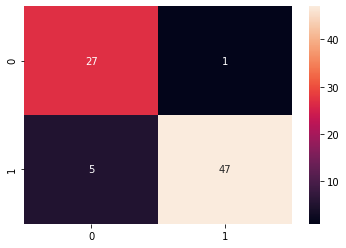

In [10]:
def plot_conf_mat(Y_pred, Y_gt):
    """
    Plots Confusion Matrix
    Args:
        Y_pred: predictions array (np.array)
        Y_gt: ground truth array (np.array)
    """
    conf_mat = pd.DataFrame(confusion_matrix(Y_gt, Y_pred, labels=[1,0]))
    sn.heatmap(conf_mat, annot=True)
    
plot_conf_mat(Y_pred, Y_test)

### Observations

After training our Logistic Regression Classifier, we observe a very high Accuracy and F1 Score, which is awesome! Lets keep track of our progress:

| Model | Observations | Accuracy | F1 | 
|:- |:- |:- | :- |
| Logistic Regression | High accuracy, very few false positives and false negatives | 90% | 92.5% |

In [11]:
trace = torch.jit.trace(model, torch.rand((1, 20)))
trace.save('suv_predictor.pt')
torch.save(model.state_dict(), 'suv_predictor_weights.pt') 